In [ ]:
from matplotlib import pyplot as plt
from matplotlib import patches
import functools as ft 
%matplotlib inline

plt.rcParams['figure.dpi'] = 300

import numpy as np
import pickle
import os
import itertools

from imitation_pretraining.experiments.evaluation import loading
from imitation_pretraining.experiments.evaluation import visualization

# Constants

In [2]:
root_path = 'PATH TO LOGS'

label_dict = {
    "Pixels + Aug": "Pixels + Aug", 
    "States": "States", 
    "bc": "BC",
    "inverse_dynamics": "ID",
    "contrastive": "FD-i",
    "SimCLR": "Cont",
    "reconstruction": "FD-e",
    "timm": "Imagenet",
    "r3m": "R3M",
    "point_mass": "Point Mass",
    "metaworld_pick_place": "Pick and Place",
    "metaworld_door": "Door",
    "kitchen": "Kitchen",
    "metaworld_0": "Metaworld (ML45 split)",
    "metaworld_r3m": "Metaworld (R3M split)",
}

color_dict = {
    "Pixels + Aug": "black", 
    "States": "deepskyblue", 
    "reconstruction": "deeppink",
    "contrastive": "darkviolet",
    "SimCLR": "royalblue",
    "inverse_dynamics": "limegreen",
    "bc": "orange",
    "timm": "maroon",
    "r3m": "lightcoral",
    
    "inverse_dynamics-2": "darkgreen",
    "inverse_dynamics-5": "seagreen",
    "inverse_dynamics-10": "lime",
    "contrastive-2": "darkviolet",
    "contrastive-5": "plum",
    "contrastive-10": "magenta",
}

envs = ["point_mass", "metaworld_pick_place", 
        "metaworld_door", "kitchen", 
        "metaworld_0", "metaworld_r3m"]

pt_defaults = {
    "point_mass": 1000,
    "metaworld_pick_place_nogoal": 1000,
    "metaworld_pretrain_split_door": 1000,
    "kitchen_split_0": 450,
    "metaworld_pretrain_split_0": 10000,
    "metaworld_pretrain_split_r3m": 10000
}

ft_defaults = {
    "point_mass": 2,
    "metaworld_pick_place_nogoal": 5,
    **{f"kitchen_split_{i}{s}": 10 for i in range(3) for s in ["", "_state"]},
    **{f"metaworld_finetune_{i}_split_{s}":10 for i in range(5) for s in ["0", "r3m", "door", "button", "plate"]}
}

# Helper functions

In [3]:
def env_match(query, config_name):
    if "door" in query:
        match = "door" in config_name
    elif "0" in query:
        match = "metaworld" in config_name and "split_0" in config_name
    elif "r3m" in query:
        match = "r3m" in config_name
    else:
        match = query in config_name
    return match

# Figure 1 + Appendix (sweep pretrain size)

In [ ]:
def label_f(g):
    return g["encoder_config"].get("max_episodes", 0)

def filter_func(g, env_name, enc_name=None, nstep=1, mode=None, obs_name=None):
    if mode == "scratch":
        if "point_mass" in g["eval_env_name"]:
            size_match = g["max_episodes"] == 2
        elif "pick_place" in g["eval_env_name"]:
            size_match = g["max_episodes"] == 5
        else:
            size_match = g["max_episodes"] == 10
        
        obs_match = obs_name in g["observation_adapter_name"]
        return obs_match and env_match(env_name, g["eval_env_name"]) and size_match
    
    enc_match = enc_name in g["encoder_name"]
    if "nstep" not in g["encoder_config"]:
        enc_match = enc_match
    elif nstep >= 0:
        enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
    return enc_match and env_match(env_name, g["eval_env_name"])

date = "Apr-2023"

finetune_id = ['32838050']
args_dict = visualization.get_args_dict(date, finetune_id)

args_dict["States"]["sweep_ids"] = ['32608183']
args_dict["Pixels + Aug"]["sweep_ids"] =  ['32608738']

fixed_id = ['32653636']
args_dict["timm"]["sweep_ids"] =  fixed_id
args_dict["r3m"]["sweep_ids"] =  fixed_id

full_results, avg_results = visualization.get_full_results(
    root_path, envs, filter_func, label_f, args_dict
)

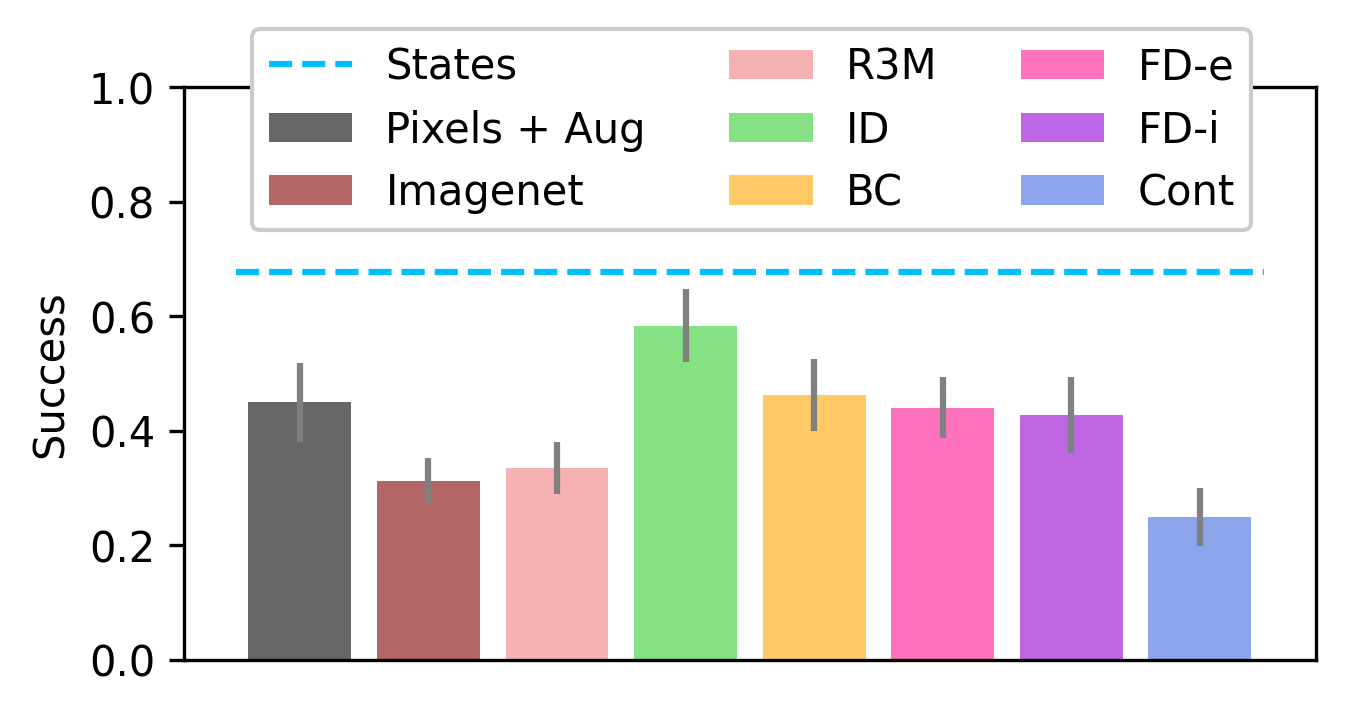

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 2.5))
fig.tight_layout()

for i, k in enumerate(args_dict):
    
    mean = avg_results[k]["means"][-1] # Only select the largest pretraining dataset
    std = avg_results[k]["stds"][-1]
    
    if k == "States":
        axs.plot([0.5, 8.5], [mean]*2, linestyle="dashed",
                               color=color_dict[k],
                               label=label_dict[k])
    else:
        axs.bar(i, mean, yerr=std, color=color_dict[k], label=label_dict[k], ecolor="gray", alpha=0.6)

    axs.set_xticks([])
    axs.set_ylim(0.0,1.0)
    axs.legend(loc=(0.06, 0.75), ncol=3, framealpha=1.0)
    axs.set_ylabel("Success")

fig.subplots_adjust(hspace=0.25)
plt.show()

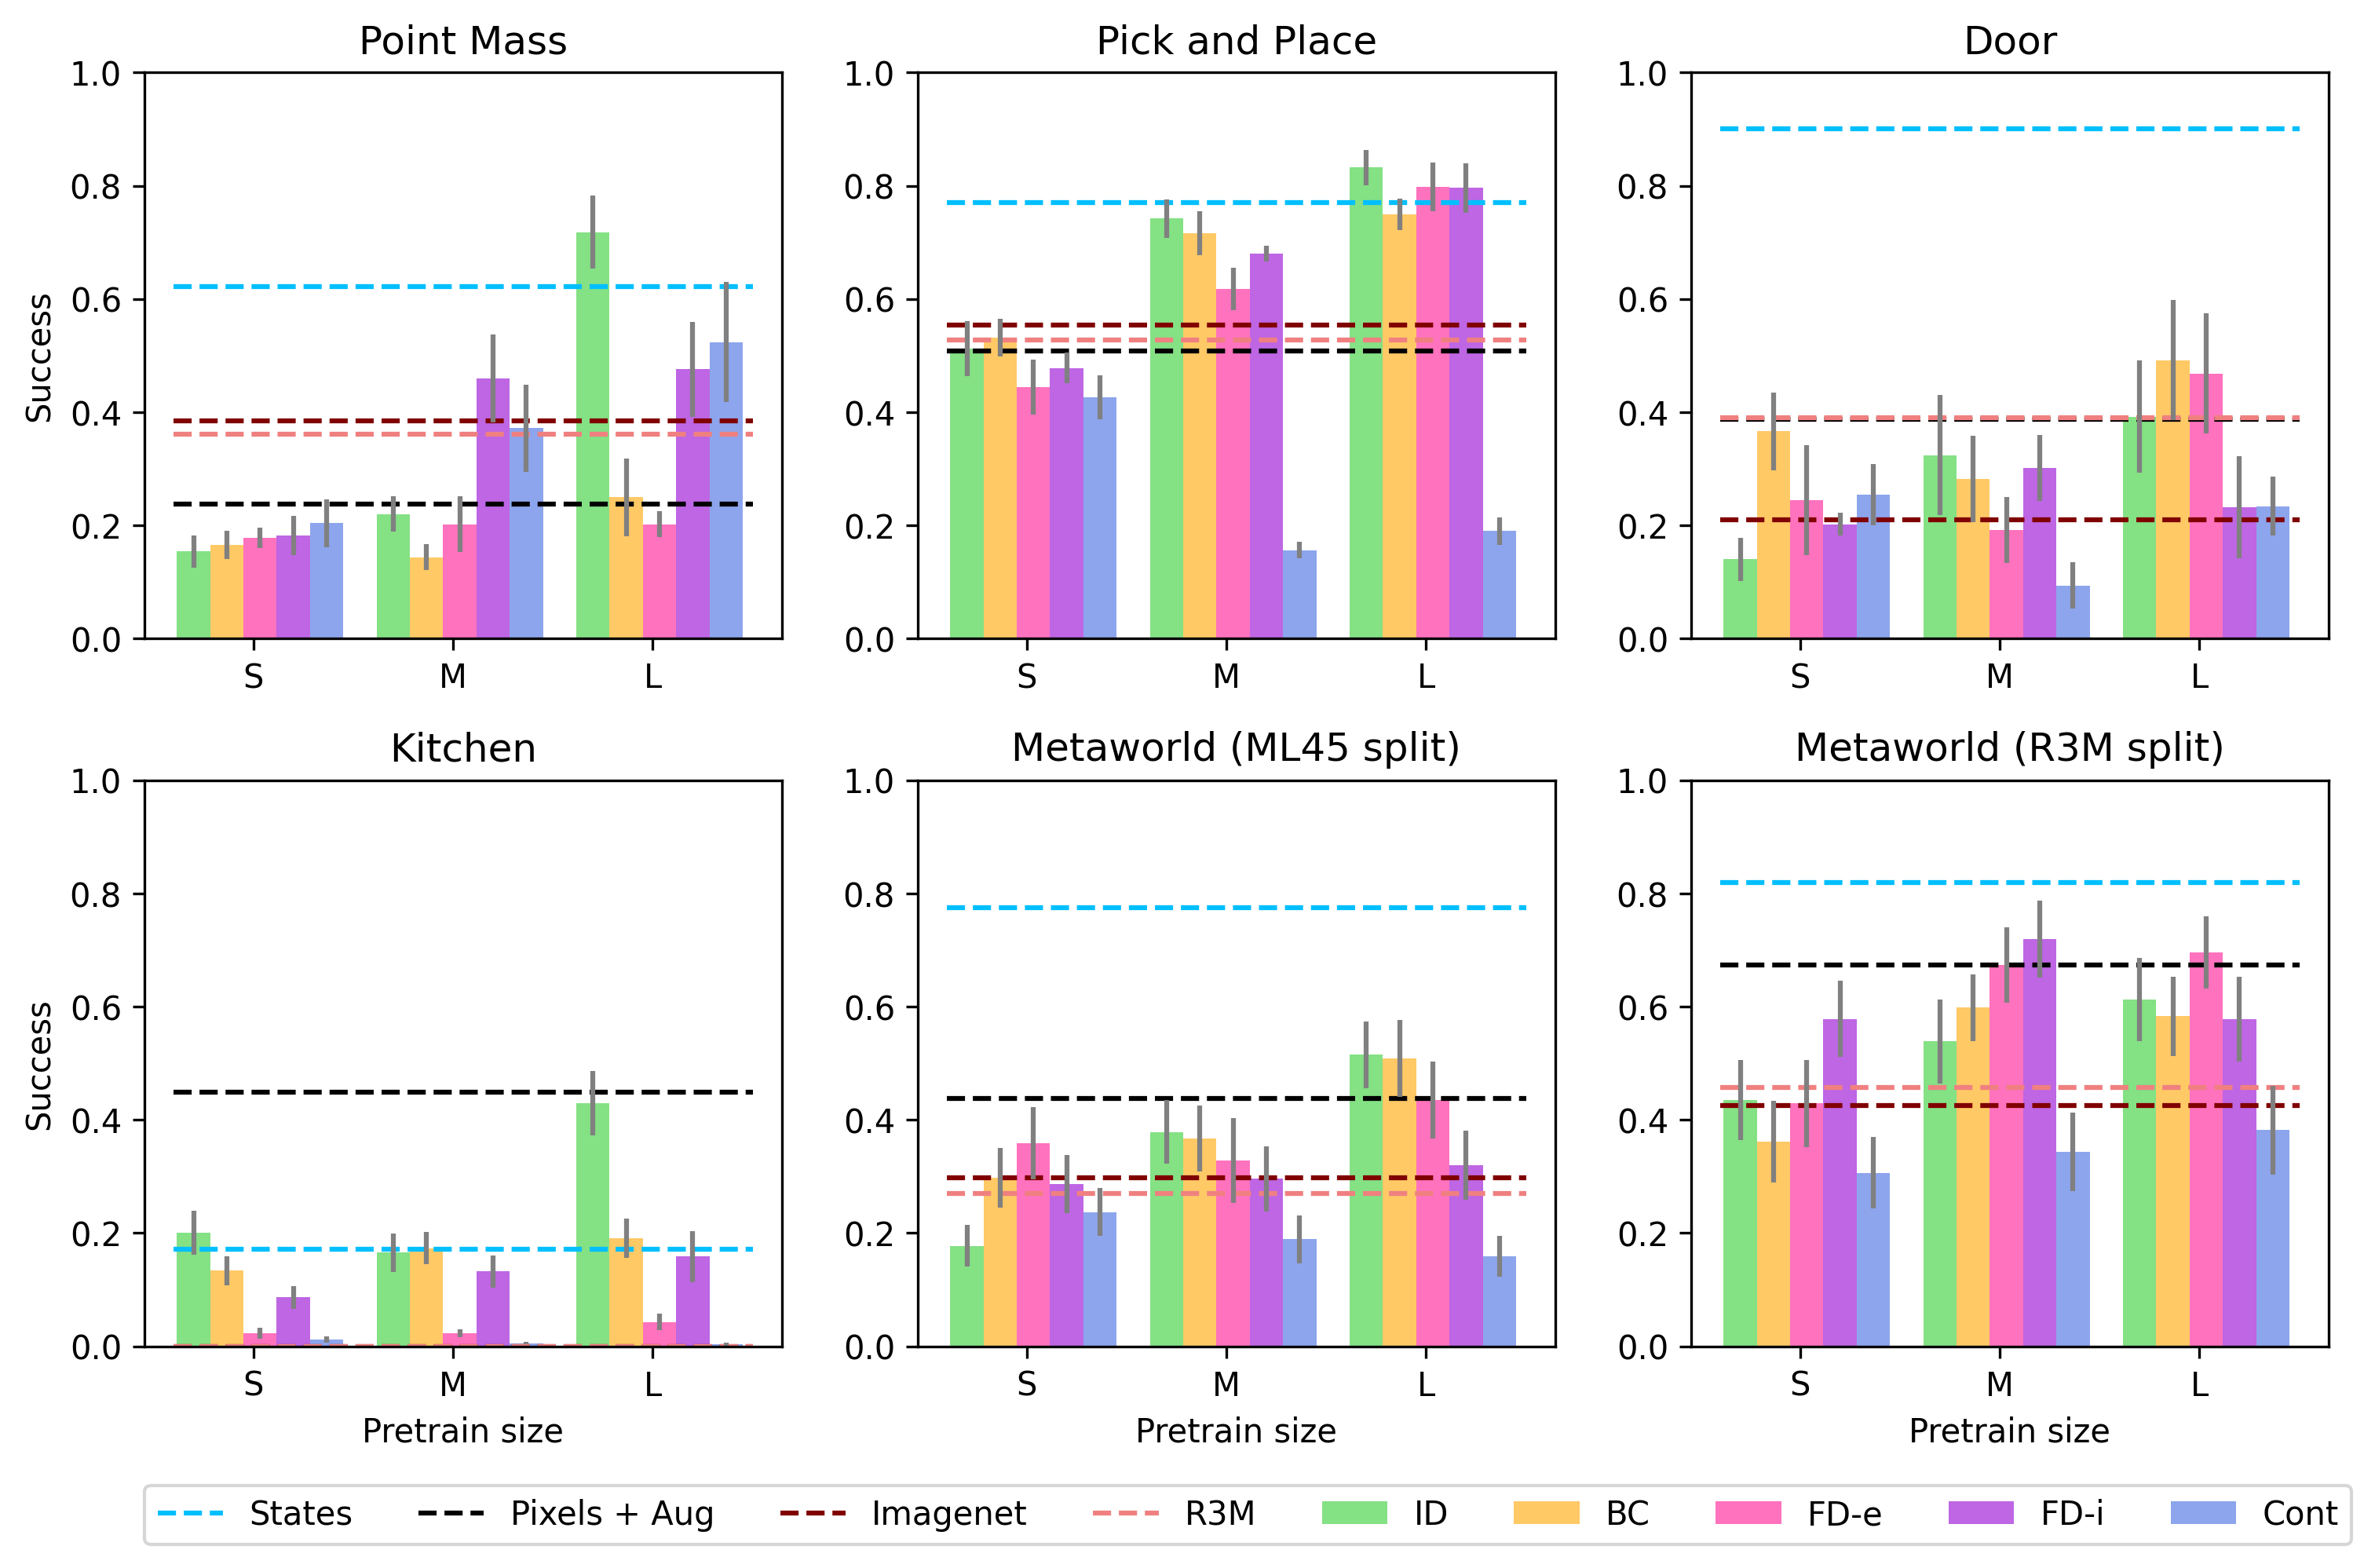

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout()

x_axis = ["S", "M", "L"]
bar_size = 6

for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3
    for idx, (alg, value) in enumerate(full_results[env_name].items()):
        if alg in ["States", "Pixels + Aug", "r3m", "timm"]:
            axs[x,y].plot(
                [-0.1, 2.8], [value["means"]] * 2, 
                linestyle='dashed',
                color=color_dict[alg], label=label_dict[alg]
            )
        else:
            for j in range(3):
                axs[x,y].bar(
                    j + (idx-4) / bar_size, value["means"][j], yerr=value["stds"][j], 
                    width=1/bar_size, alpha=0.6, ecolor="gray", 
                    color=color_dict[alg], label=label_dict[alg] if j == 0 else None
                )
    
    
    axs[x,y].set_xticks([j + 0.3 for j in range(3)], x_axis)
    axs[x,y].set_title(label_dict[env_name])
    axs[x,y].set_ylim(0,1)
    if x == 1:
        axs[x,y].set_xlabel("Pretrain size")
    if x == 1 and y == 0:
        axs[x,y].legend(loc=(0.0, -0.35), ncol=9)
    if y == 0:
        axs[x,y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

In [7]:
full_results_pt = full_results.copy()
avg_results_pt = avg_results.copy()

# Figure 3 + appendix (sweep finetune size)

In [ ]:
def label_f(g):
    return g["max_episodes"]

def filter_func(g, env_name, mode, obs_name=None, enc_name=None, nstep=1):
    if mode == "scratch":
        obs_match = obs_name in g["observation_adapter_name"]
        return obs_match and env_match(env_name, g["eval_env_name"])
    elif mode == "finetune":
        enc_match = enc_name in g["encoder_name"]
        if "nstep" in g["encoder_config"]:
            enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
        return enc_match and env_match(env_name, g["eval_env_name"])
    else:
        raise NotImplemented

    
date = "Apr-2023"

finetune_id = ['32850691']

args_dict = visualization.get_args_dict(date, finetune_id)

args_dict["States"]["sweep_ids"] = ['32608183']
args_dict["Pixels + Aug"]["sweep_ids"] =  ['32608738']

fixed_id = ['32653636']
args_dict["timm"]["sweep_ids"] =  fixed_id
args_dict["r3m"]["sweep_ids"] =  fixed_id

full_results_ft, avg_results_ft = visualization.get_full_results(root_path, envs, filter_func, label_f, args_dict)

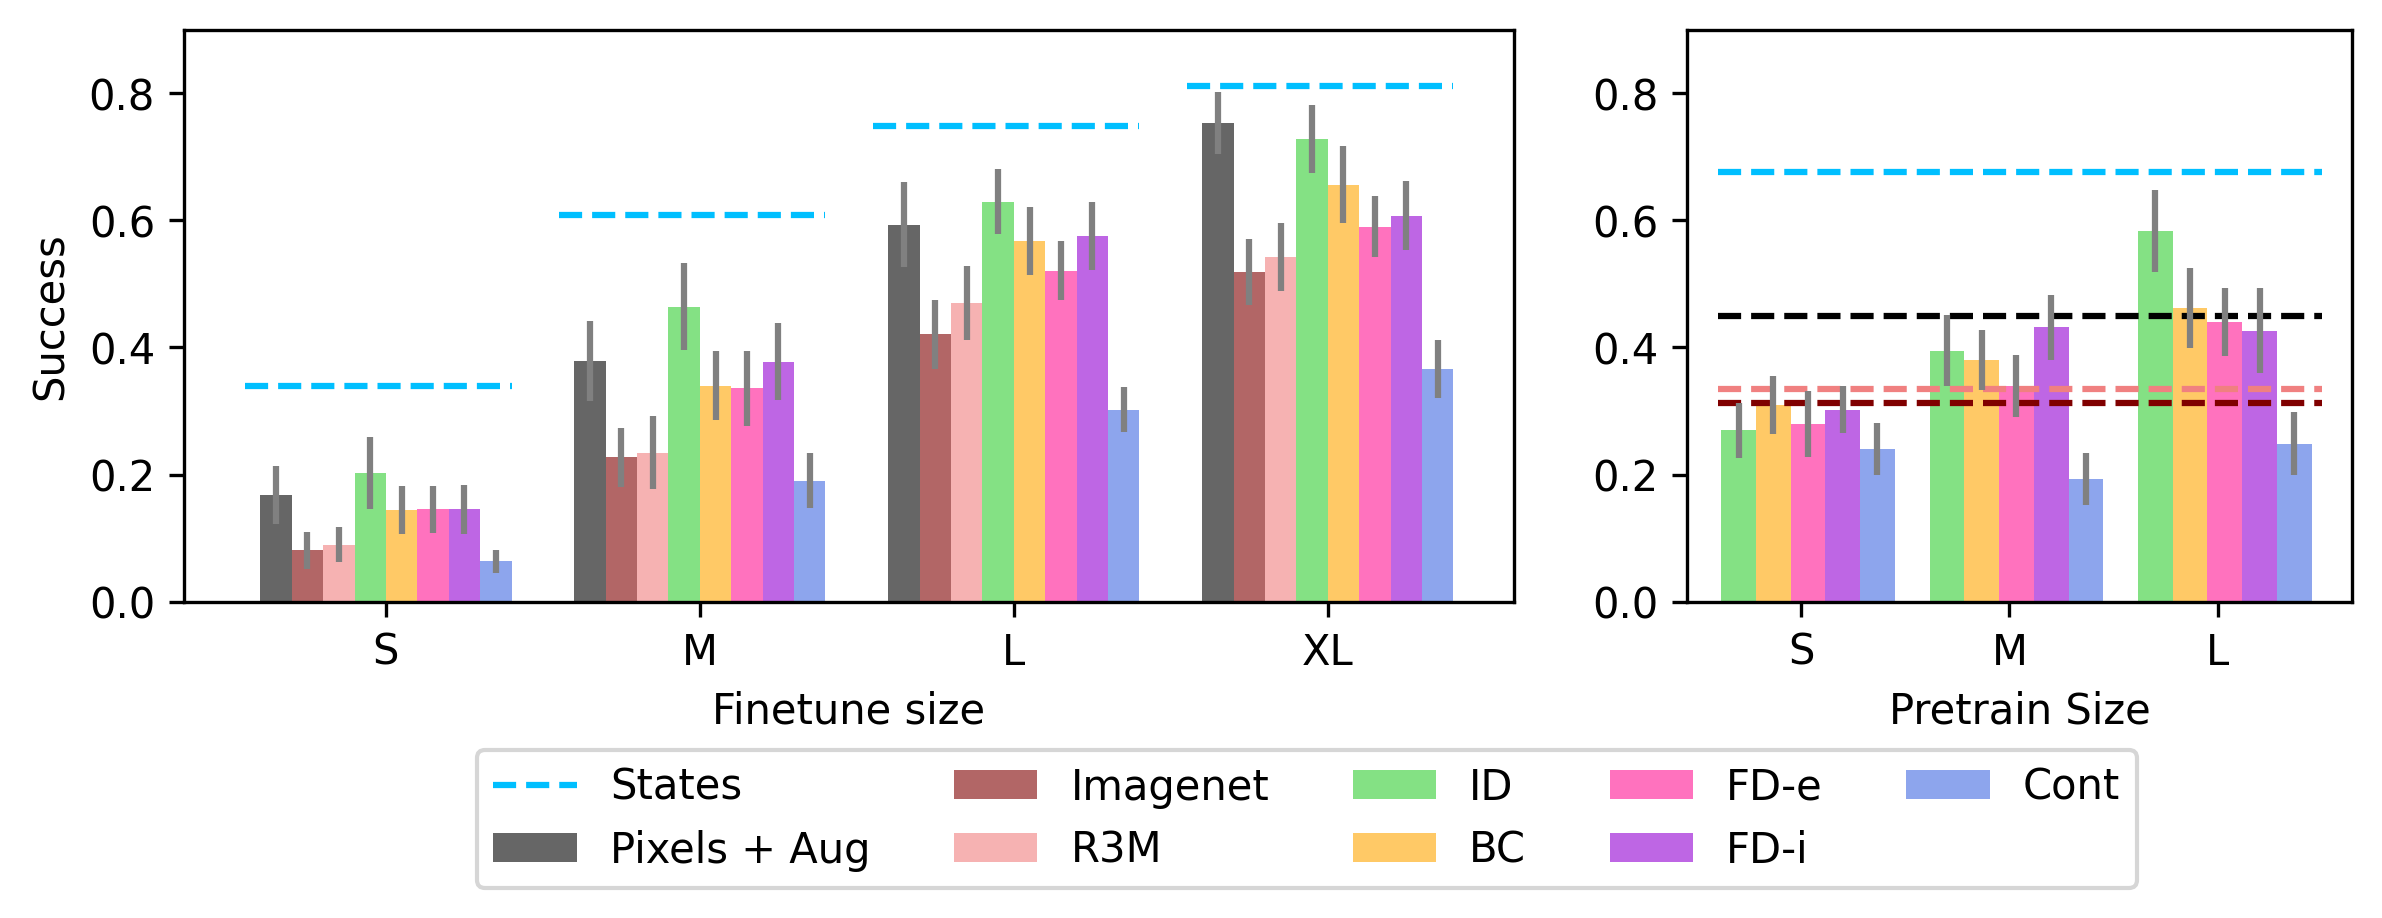

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), gridspec_kw={'width_ratios': [4, 2]})
fig.tight_layout()
                      
for y, avg_results in enumerate([avg_results_ft, avg_results_pt]):

    for i, alg in enumerate(avg_results):
        value = avg_results[alg]
        
        if y == 0:
            axs[y].set_xticks([j + 0.45 for j in range(4)], ["S", "M", "L", "XL"])
            bar_size = 10
            for j in range(4):
                if alg == "States":
                    axs[y].plot([j, j+0.85], [value["means"][j]]*2, linestyle="dashed",
                               color=color_dict[alg], label=label_dict[alg] if j == 0 else None)
                else:
                    axs[y].bar(j + i / bar_size, value["means"][j], yerr=value["stds"][j], 
                               width=1/bar_size, alpha=0.6,
                               color=color_dict[alg],  ecolor="gray", label=label_dict[alg] if j == 0 else None)
            
        
        if y == 1:
            axs[y].set_xticks([j + 0.3 for j in range(3)], ["S", "M", "L"])
            bar_size = 6
            if alg in ["States", "Pixels + Aug", "r3m", "timm"]:
                axs[y].plot([-0.1, 2.8], [value["means"]] * 2,
                            linestyle="dashed",
                            color=color_dict[alg], label=label_dict[alg] if j == 0 else None)
            else:
                for j in range(3):
                    axs[y].bar(j + (i-4) / bar_size, value["means"][j], yerr=value["stds"][j], 
                               width=1/bar_size, alpha=0.6,
                               color=color_dict[alg], ecolor="gray",
                               label=label_dict[alg] if j == 0 else None)


    axs[y].set_ylim(0.0,0.9)
    axs[y].set_xlabel(["Finetune size", "Pretrain Size"][y])
    if y == 0:
        axs[y].legend(loc=(0.22, -0.5), ncol=5)
        axs[y].set_ylabel("Success")

fig.subplots_adjust(hspace=0.25)
plt.show()

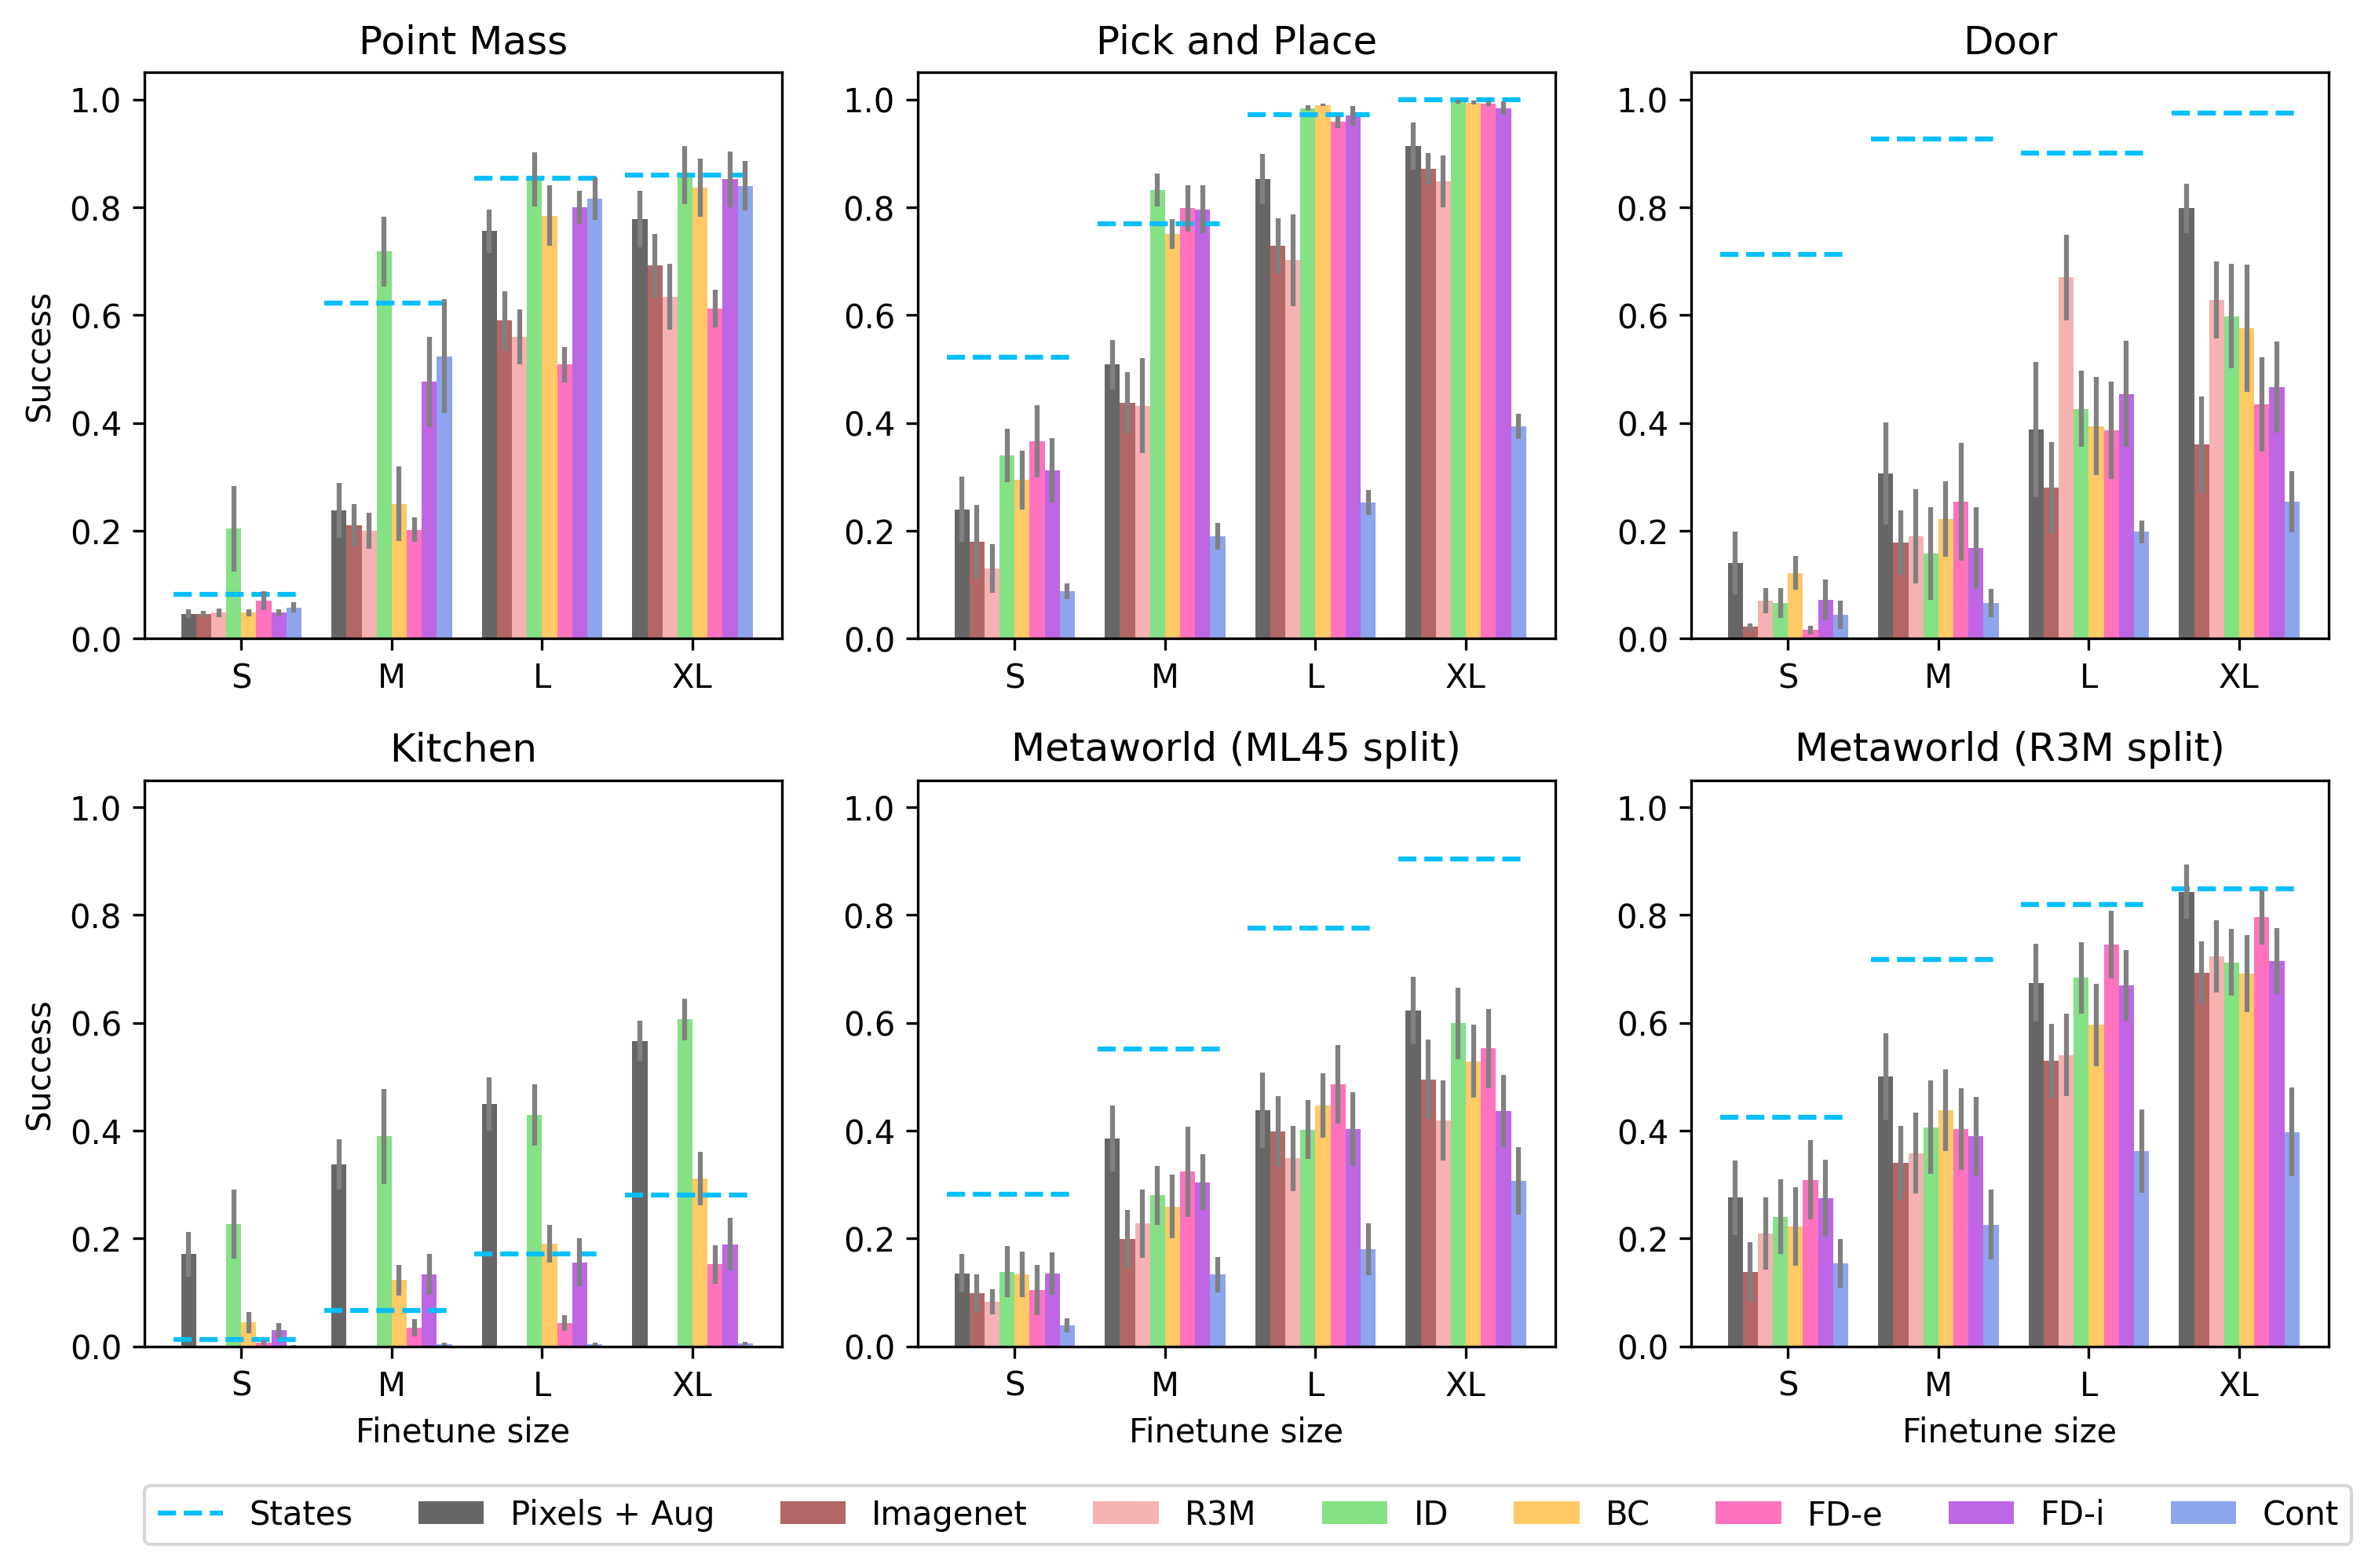

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout()

x_axis = ["S", "M", "L", "XL"]
bar_size = 10

for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3
    for idx, (alg, value) in enumerate(full_results_ft[env_name].items()):
        for j in range(4):
            if alg == "States":
                axs[x,y].plot([j, j+0.85], [value["means"][j]]*2, linestyle="dashed",
                           color=color_dict[alg], label=label_dict[alg] if j == 0 else None)
            else:
                axs[x,y].bar(j + idx / bar_size, value["means"][j], yerr=value["stds"][j], 
                           width=1/bar_size, alpha=0.6,
                           color=color_dict[alg],  ecolor="gray", label=label_dict[alg] if j == 0 else None)
    
    axs[x,y].set_xticks([j + 0.45 for j in range(4)], x_axis)
    axs[x,y].set_title(label_dict[env_name])
    axs[x,y].set_ylim(0,1.05)
    if x == 1:
        axs[x,y].set_xlabel("Finetune size")
    if x == 1 and y == 0:
        axs[x,y].legend(loc=(0.0, -0.35), ncol=9)
    if y == 0:
        axs[x,y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

# Figure 4 + appendix (ablating in distribution)

In [ ]:
def label_f(g):
    return g["max_episodes"]

def filter_func(g, env_name, mode, obs_name=None, enc_name=None, nstep=1):
    if mode == "scratch":
        obs_match = obs_name in g["observation_adapter_name"]
        return obs_match and env_match(env_name, g["eval_env_name"])
    elif mode == "finetune":
        enc_match = enc_name in g["encoder_name"]
        if "nstep" in g["encoder_config"]:
            enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
        return enc_match and env_match(env_name, g["eval_env_name"])
    else:
        raise NotImplemented

    
date = "Apr-2023"
finetune_id = ['32850691']
args_dict = visualization.get_args_dict(date, finetune_id)
args_dict["States"]["sweep_ids"] = ['32608183']
args_dict["Pixels + Aug"]["sweep_ids"] =  ['32608738']

fixed_id = ['32653636']
args_dict["timm"]["sweep_ids"] =  fixed_id
args_dict["r3m"]["sweep_ids"] =  fixed_id
    
full_results, _ = visualization.get_full_results(root_path, envs, filter_func, label_f, args_dict)

date = "May-2023"
finetune_id = ['32950576']
args_dict = visualization.get_args_dict(date, finetune_id)
full_results_2, _ = visualization.get_full_results(root_path, envs, filter_func, label_f, args_dict)

for env in full_results:
    if env not in ["point_mass", "metaworld_pick_place"]:
        for alg in ["bc", "inverse_dynamics", "contrastive", "reconstruction", "SimCLR"]:
            if alg in full_results_2[env]:
                full_results[env][alg] = full_results_2[env][alg]
                
avg_results = visualization.get_avg(full_results)

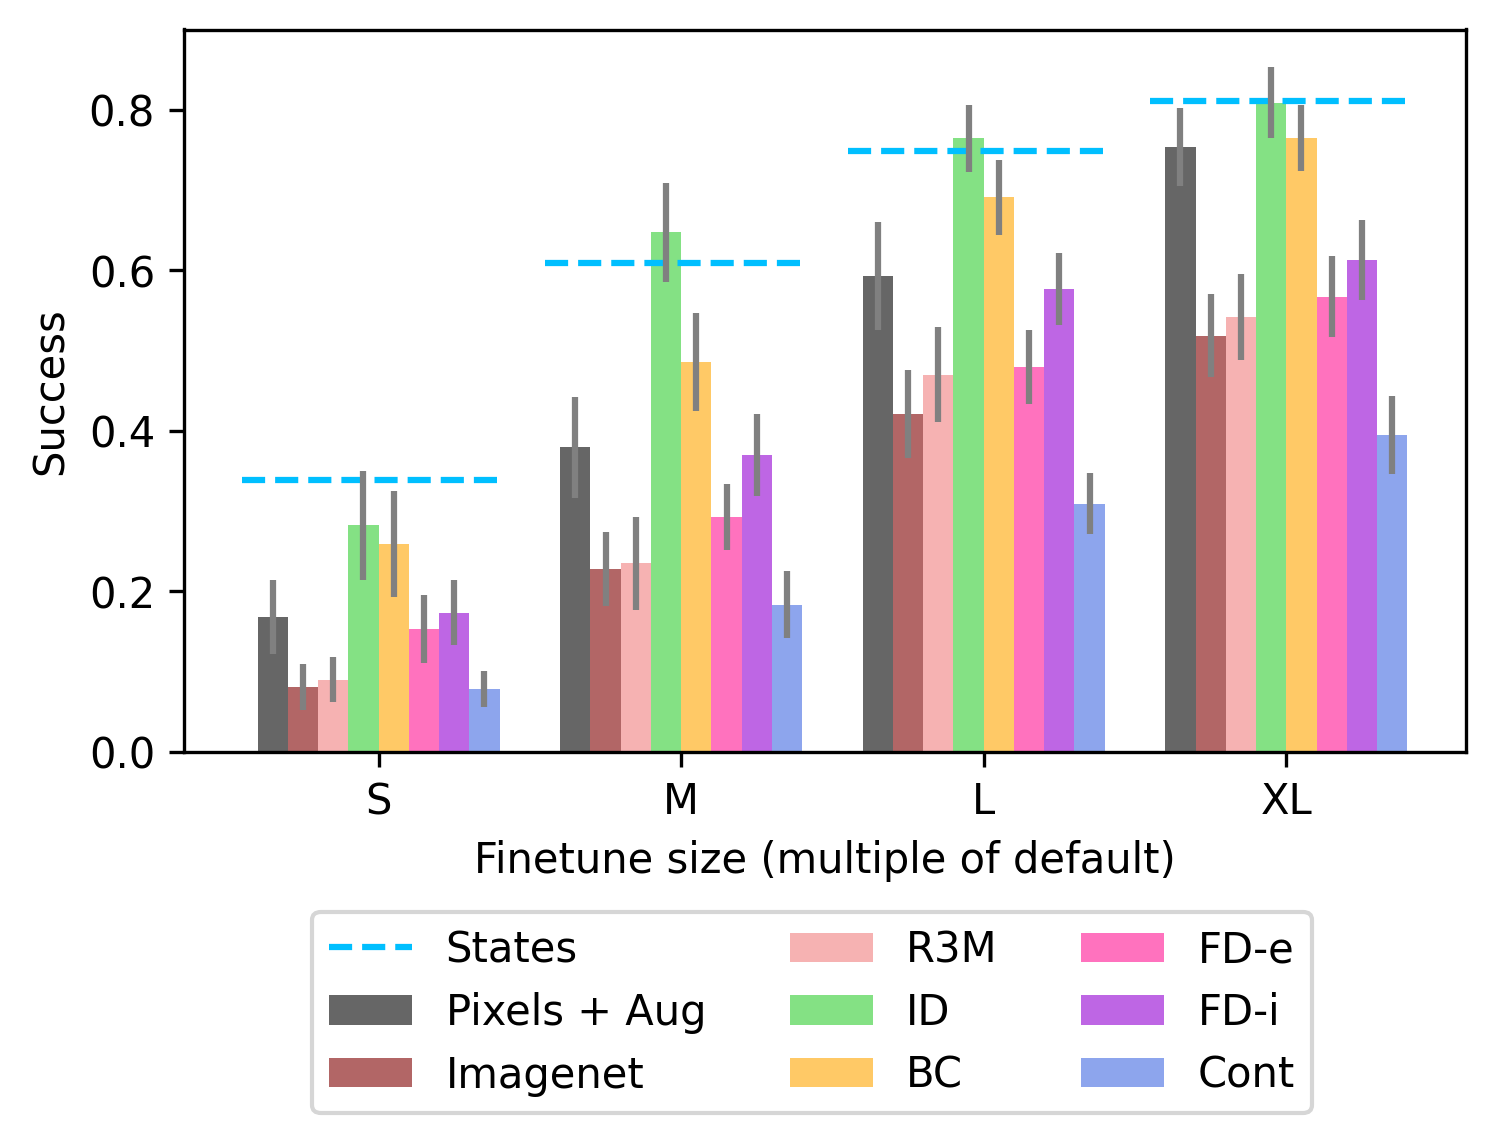

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig.tight_layout()
    
bar_size = 10
    
for idx, alg in enumerate(list(avg_results.keys())):
    value = avg_results[alg]
    
    for j in range(4):
        if alg == "States":
            ax.plot([j, j+0.85], [value["means"][j]]*2, linestyle="dashed",
                       color=color_dict[alg], label=label_dict[alg] if j == 0 else None)
        else:
            ax.bar(j + idx / bar_size, value["means"][j], yerr=value["stds"][j], 
                       width=1/bar_size, alpha=0.6,
                       color=color_dict[alg],  ecolor="gray", label=label_dict[alg] if j == 0 else None)
    
    ax.set_xticks([j + 0.45 for j in range(4)], ["S", "M", "L", "XL"])
    ax.set_ylim(0.0,0.9)
    ax.set_xlabel("Finetune size (multiple of default)")
    ax.legend(loc=(0.1, -0.5), ncol=3)
    ax.set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

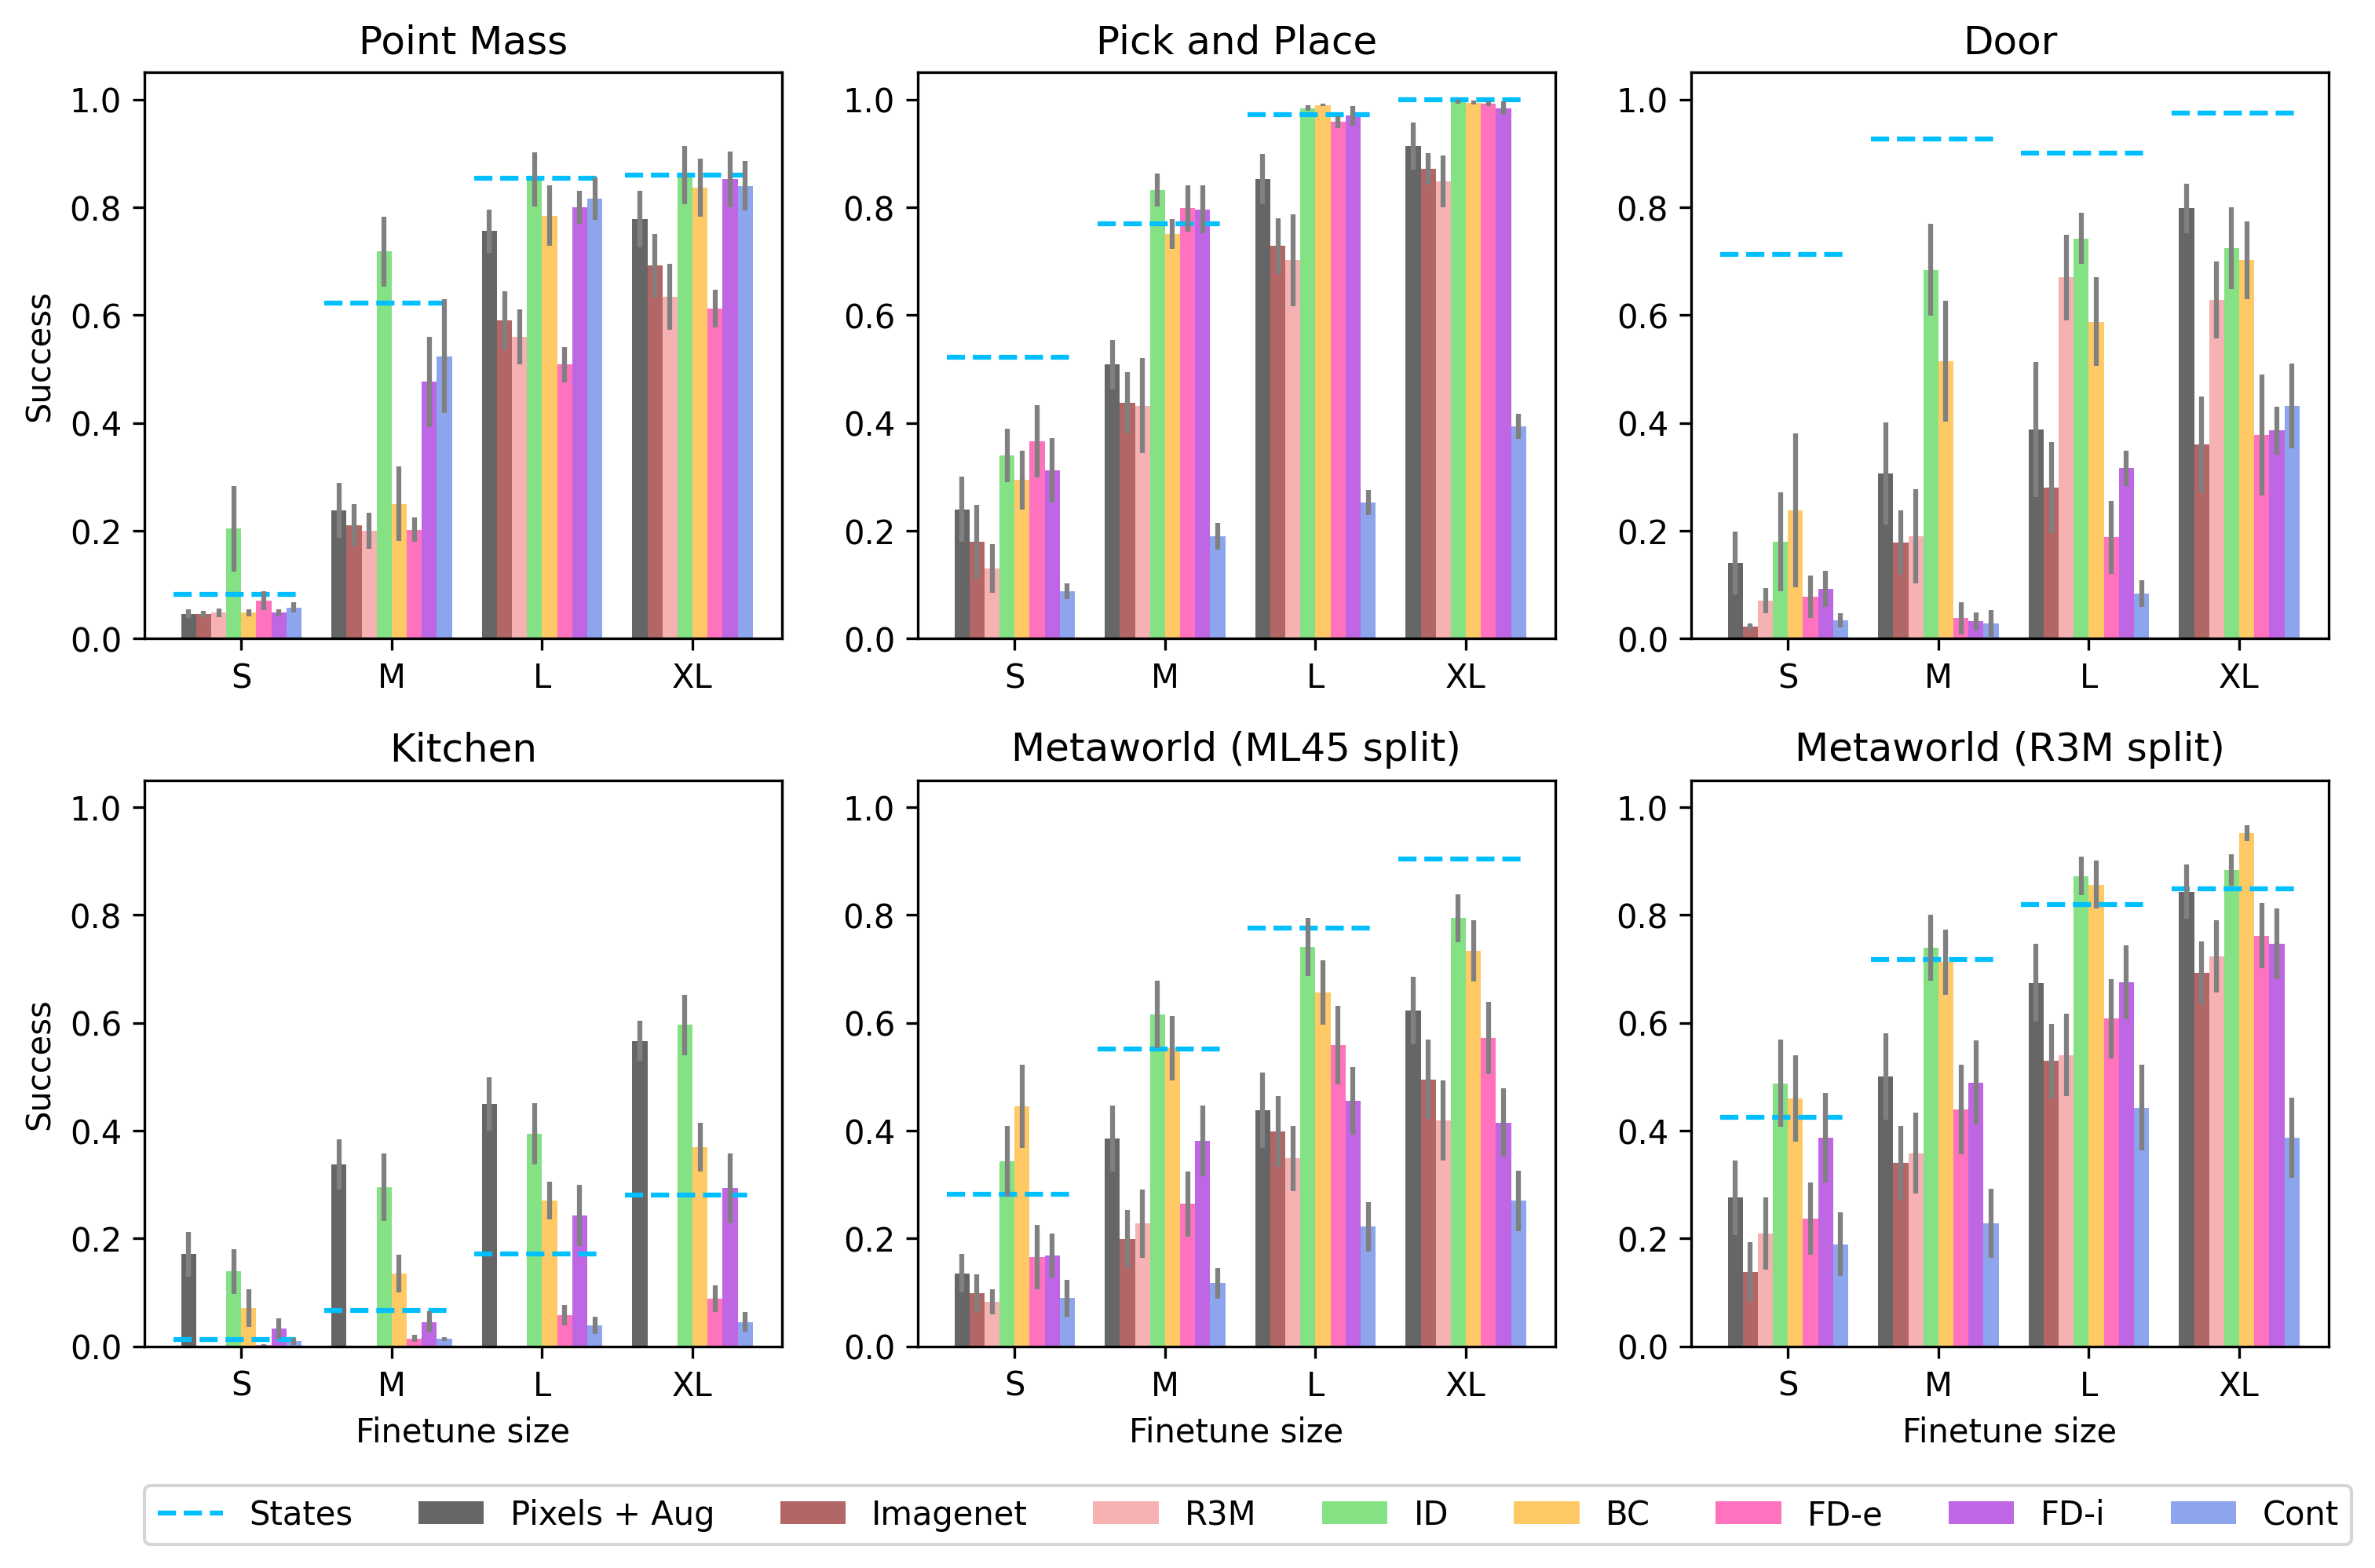

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout()

x_axis = ["S", "M", "L", "XL"]
bar_size = 10

for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3
    for idx, (alg, value) in enumerate(full_results[env_name].items()):
        for j in range(4):
            if alg == "States":
                axs[x,y].plot([j, j+0.85], [value["means"][j]]*2, linestyle="dashed",
                           color=color_dict[alg], label=label_dict[alg] if j == 0 else None)
            else:
                axs[x,y].bar(j + idx / bar_size, value["means"][j], yerr=value["stds"][j], 
                           width=1/bar_size, alpha=0.6,
                           color=color_dict[alg],  ecolor="gray", label=label_dict[alg] if j == 0 else None)
    
    axs[x,y].set_xticks([j + 0.45 for j in range(4)], x_axis)
    axs[x,y].set_title(label_dict[env_name])
    axs[x,y].set_ylim(0,1.05)
    if x == 1:
        axs[x,y].set_xlabel("Finetune size")
    if x == 1 and y == 0:
        axs[x,y].legend(loc=(0.0, -0.35), ncol=9)
    if y == 0:
        axs[x,y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

# Figure 5 + appendix (latent context)

In [14]:
split_full_results_ft = full_results_ft.copy()

latent_envs = ['point_mass', 'metaworld_pick_place', 'kitchen']
obs_envs = ['metaworld_door', 'metaworld_0', 'metaworld_r3m']

latent_results = {}
for env in latent_envs:
    latent_results[env] = split_full_results_ft[env]
obs_results = {}
for env in obs_envs:
    obs_results[env] = split_full_results_ft[env]

latent_avg = visualization.get_avg(latent_results)
obs_avg = visualization.get_avg(obs_results)

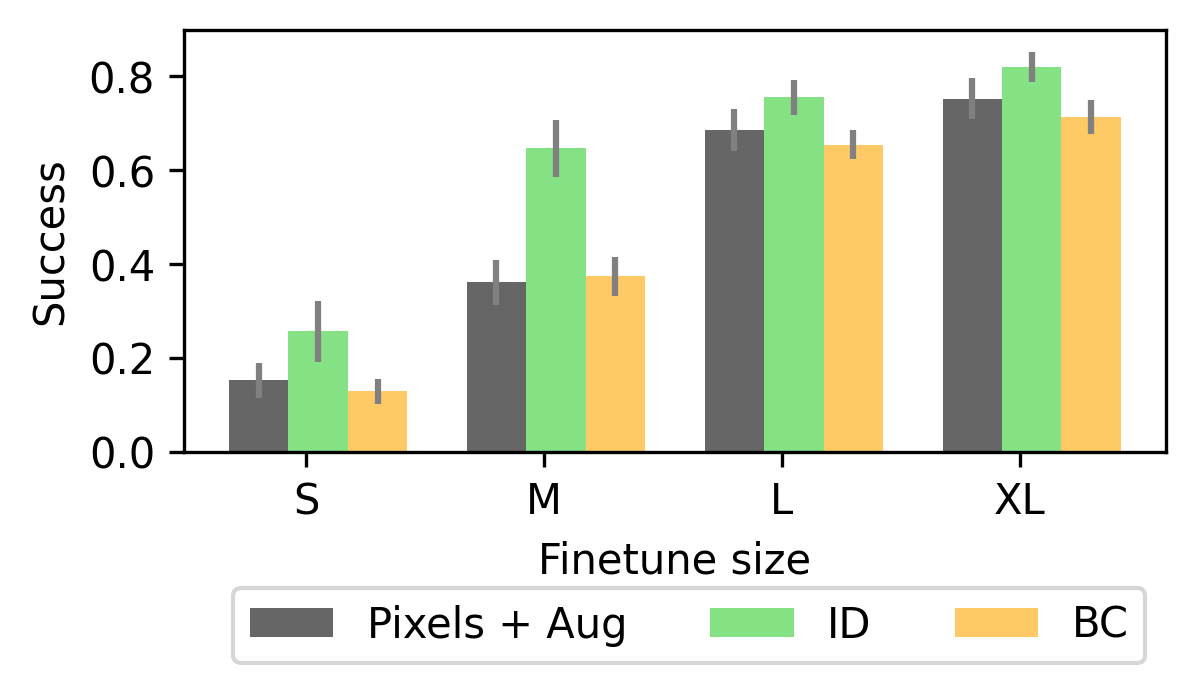

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(4, 2))
fig.tight_layout()

d = {1:0, 4:1, 5:2}
bar_size = 4                    

for y, avg_results in enumerate([latent_avg,]):

    for i, alg in enumerate(avg_results):
        if alg in ["bc", "inverse_dynamics", "Pixels + Aug"]:
            value = avg_results[alg]
            
            for j in range(4):
                axs.bar(j + d[i] / bar_size, value["means"][j], yerr=value["stds"][j], 
                        width=1/bar_size, alpha=0.6,
                        color=color_dict[alg], ecolor="gray",
                        label=label_dict[alg] if j == 0 else None)

    axs.set_xticks([j + 0.2 for j in range(4)], ["S", "M", "L", "XL"])
    axs.set_ylim(0.0,0.9)
    axs.set_xlabel("Finetune size")
    if y == 0:
        axs.legend(loc=(0.05, -0.5), ncol=9)
        axs.set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

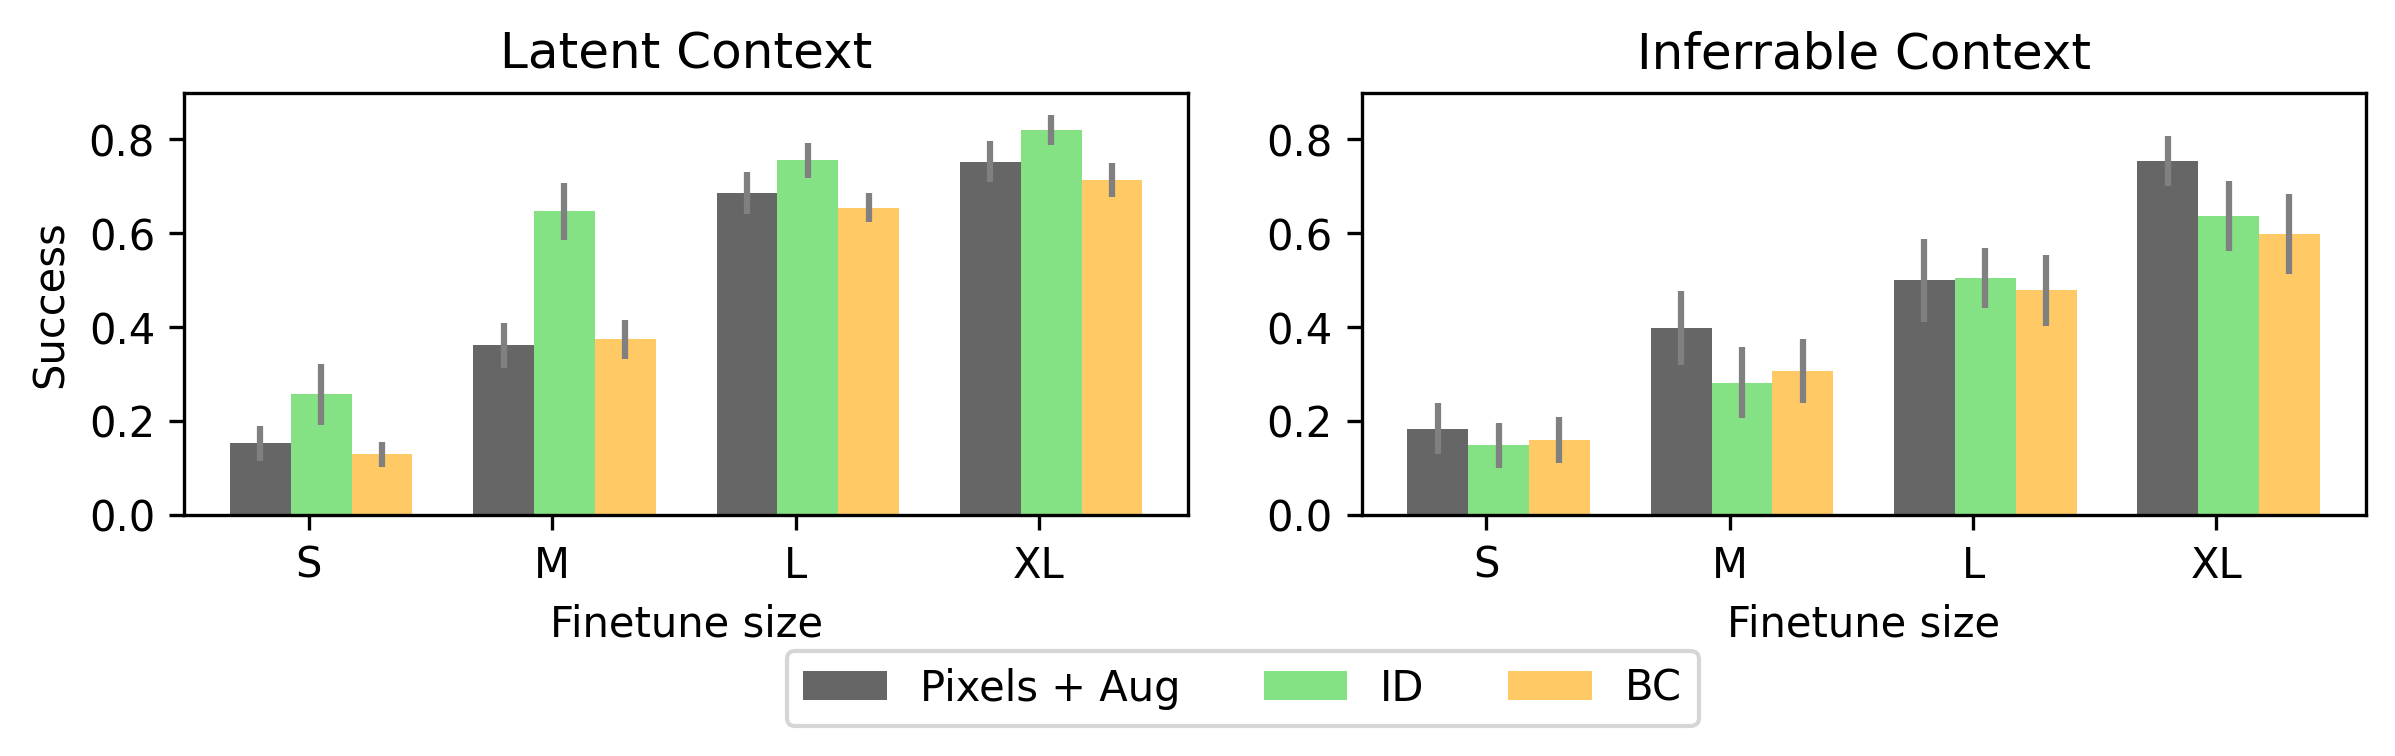

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
fig.tight_layout()

d = {1:0, 4:1, 5:2}
bar_size = 4                    

for y, avg_results in enumerate([latent_avg, obs_avg]):

    for i, alg in enumerate(avg_results):
        if alg in ["bc", "inverse_dynamics", "Pixels + Aug"]:
            value = avg_results[alg]
            
            for j in range(4):
                axs[y].bar(j + d[i] / bar_size, value["means"][j], yerr=value["stds"][j], 
                        width=1/bar_size, alpha=0.6,
                        color=color_dict[alg], ecolor="gray",
                        label=label_dict[alg] if j == 0 else None)
    
    axs[y].set_title(["Latent Context", "Inferrable Context"][y])
    axs[y].set_xticks([j + 0.2 for j in range(4)], ["S", "M", "L", "XL"])
    axs[y].set_ylim(0.0,0.9)
    axs[y].set_xlabel("Finetune size")
    if y == 0:
        axs[y].legend(loc=(0.6, -0.5), ncol=9)
        axs[y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

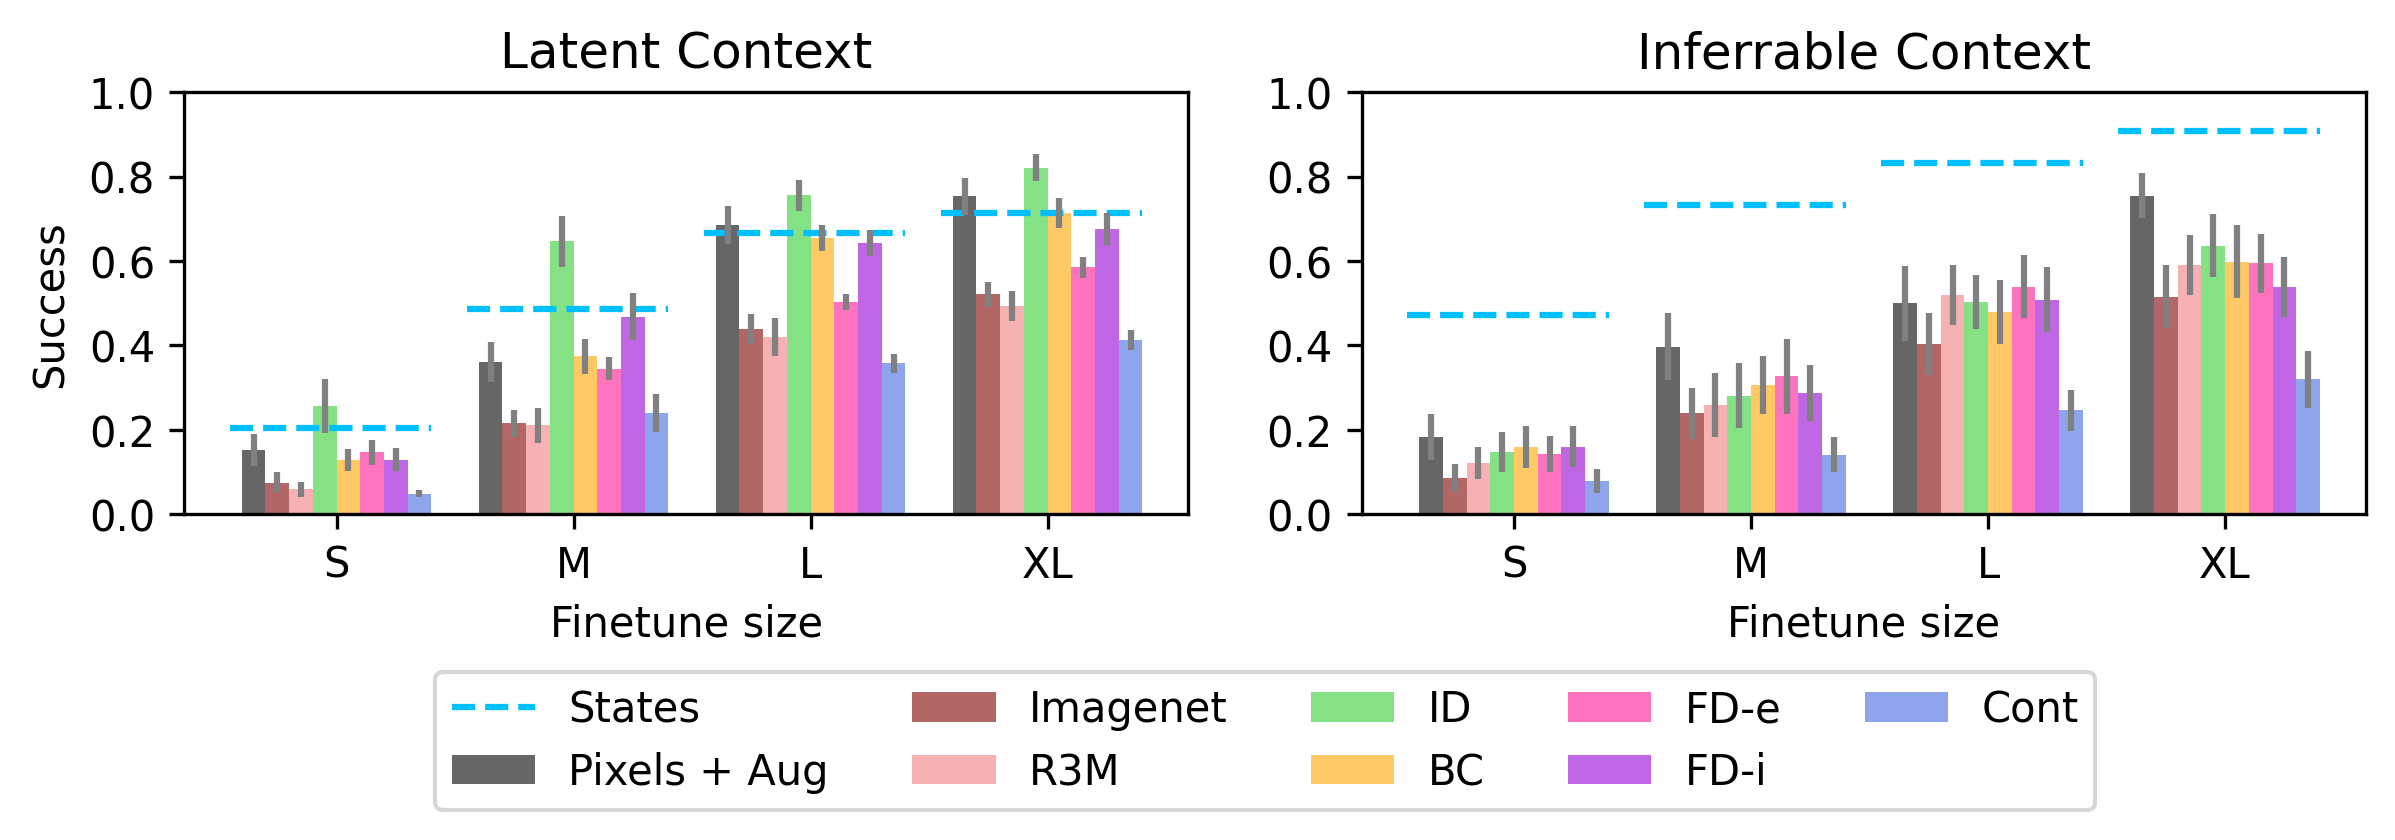

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 2))
fig.tight_layout()

bar_size = 10                    

for y, avg_results in enumerate([latent_avg, obs_avg]):

    for i, alg in enumerate(avg_results):
        value = avg_results[alg]

        for j in range(4):
            if alg == "States":
                axs[y].plot([j, j+0.85], [value["means"][j]]*2, linestyle="dashed",
                           color=color_dict[alg], label=label_dict[alg] if j == 0 else None)
            else:
                axs[y].bar(j + i / bar_size, value["means"][j], yerr=value["stds"][j], 
                        width=1/bar_size, alpha=0.6,
                        color=color_dict[alg], ecolor="gray",
                        label=label_dict[alg] if j == 0 else None)
    
    axs[y].set_title(["Latent Context", "Inferrable Context"][y])
    axs[y].set_xticks([j + 0.45 for j in range(4)], ["S", "M", "L", "XL"])
    axs[y].set_ylim(0.0,1.0)
    axs[y].set_xlabel("Finetune size")
    if y == 0:
        axs[y].legend(loc=(0.25, -0.7), ncol=5)
        axs[y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

# Figure 6 + appendix (BC loss)

In [18]:
def label_f(g):
    return g["max_episodes"]

def filter_func(g, env_name, mode, obs_name=None, enc_name=None, nstep=1):
    if mode == "scratch" or enc_name in ["timm", "r3m"]:
        size_match = g["max_episodes"] == ft_defaults[g["eval_env_name"]]
        if mode == "scratch":
            obs_match = obs_name in g["observation_adapter_name"]
            return obs_match and env_match(env_name, g["eval_env_name"]) and size_match
        else:
            enc_match = enc_name in g["encoder_name"]
            return enc_match and env_match(env_name, g["eval_env_name"]) and size_match
    
    elif mode == "finetune":
        enc_config = g["encoder_config"]
        size_match = enc_config["max_episodes"] == pt_defaults[enc_config['eval_env_name']]
        enc_match = enc_name in g["encoder_name"]
        if "nstep" in g["encoder_config"]:
            enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
        return enc_match and env_match(env_name, g["eval_env_name"]) and size_match
    else:
        raise NotImplemented
    
date = "Apr-2023"

finetune_id = ['32838050']

args_dict = visualization.get_args_dict(date, finetune_id)

args_dict["States"]["sweep_ids"] = ['32608183']
args_dict["Pixels + Aug"]["sweep_ids"] =  ['32608738']

fixed_id = ['32653636']
args_dict["timm"]["sweep_ids"] =  fixed_id
args_dict["r3m"]["sweep_ids"] =  fixed_id

full_results = {}
for csv_mode in ["train", "val"]:
    for k in args_dict:
        args_dict[k]["csv_mode"] = csv_mode
        args_dict[k]["csv_key"] = "actor_loss"
    
    full_results[csv_mode], _ = visualization.get_full_results(
        root_path, envs, filter_func, label_f, args_dict
    )

In [19]:
# Normalize results
norms = {}
for env,env_dict in full_results["train"].items():
    norms[env] = 1.0 * full_results["val"][env]["Pixels + Aug"]["means"][-1]

avg_results = {}
for csv_mode in ["train", "val"]: 
    avg_results[csv_mode] = visualization.get_avg(full_results[csv_mode], norms)

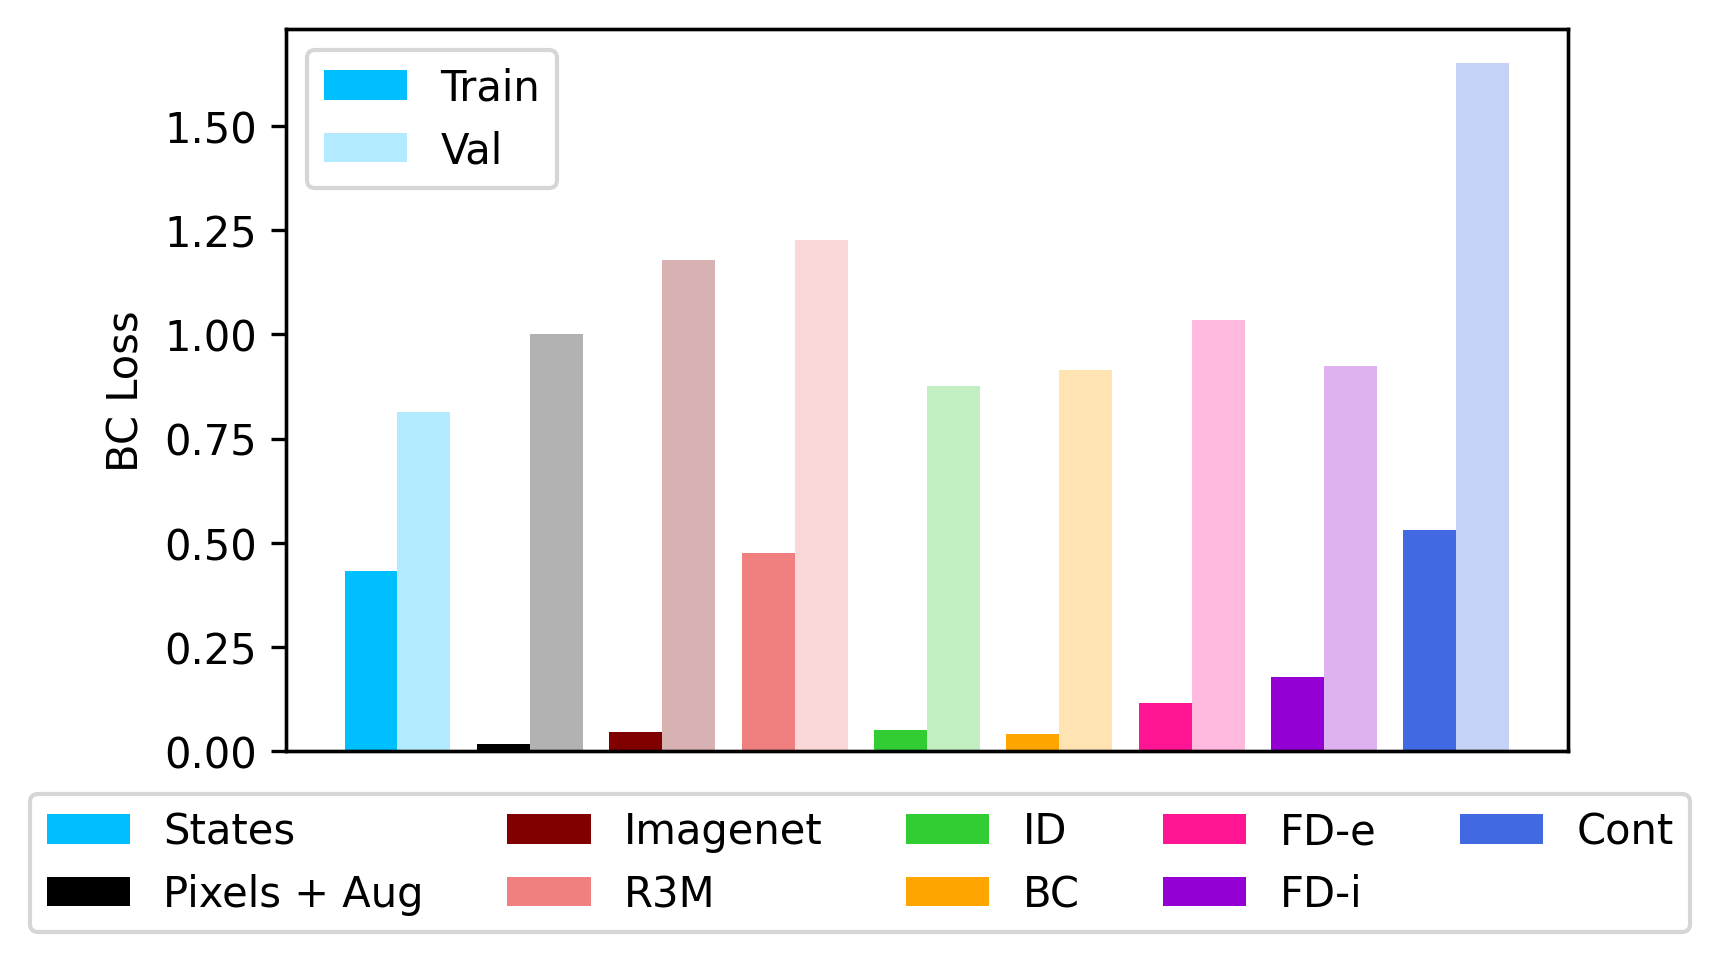

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
fig.tight_layout()

idx = 0
for loc, alg in enumerate(avg_results["train"]):

    train_loss = avg_results["train"][alg]["means"][idx]
    val_loss = avg_results["val"][alg]["means"][idx]
    
    ax.bar(
        loc, train_loss, bottom = 0, width=0.4,
        alpha=1.0, color=color_dict[alg], label=label_dict[alg]
    )
    ax.bar(
        loc+0.4, val_loss, bottom = 0, width=0.4,
        alpha=0.3, color=color_dict[alg],
    )
    
ax.set_xticks([])
ax.legend(loc=(-0.2, -0.25), ncol=5)
ax.set_ylabel("BC Loss")

ax2 = ax.twinx()
alphas = [1.0, 0.3]
labels = ["Train", "Val"]
for i in range(2):
    ax2.bar(np.NaN, np.NaN, alpha=alphas[i], label=labels[i],  color='deepskyblue')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc="upper left")
        

fig.subplots_adjust(hspace=0.25)
plt.show()

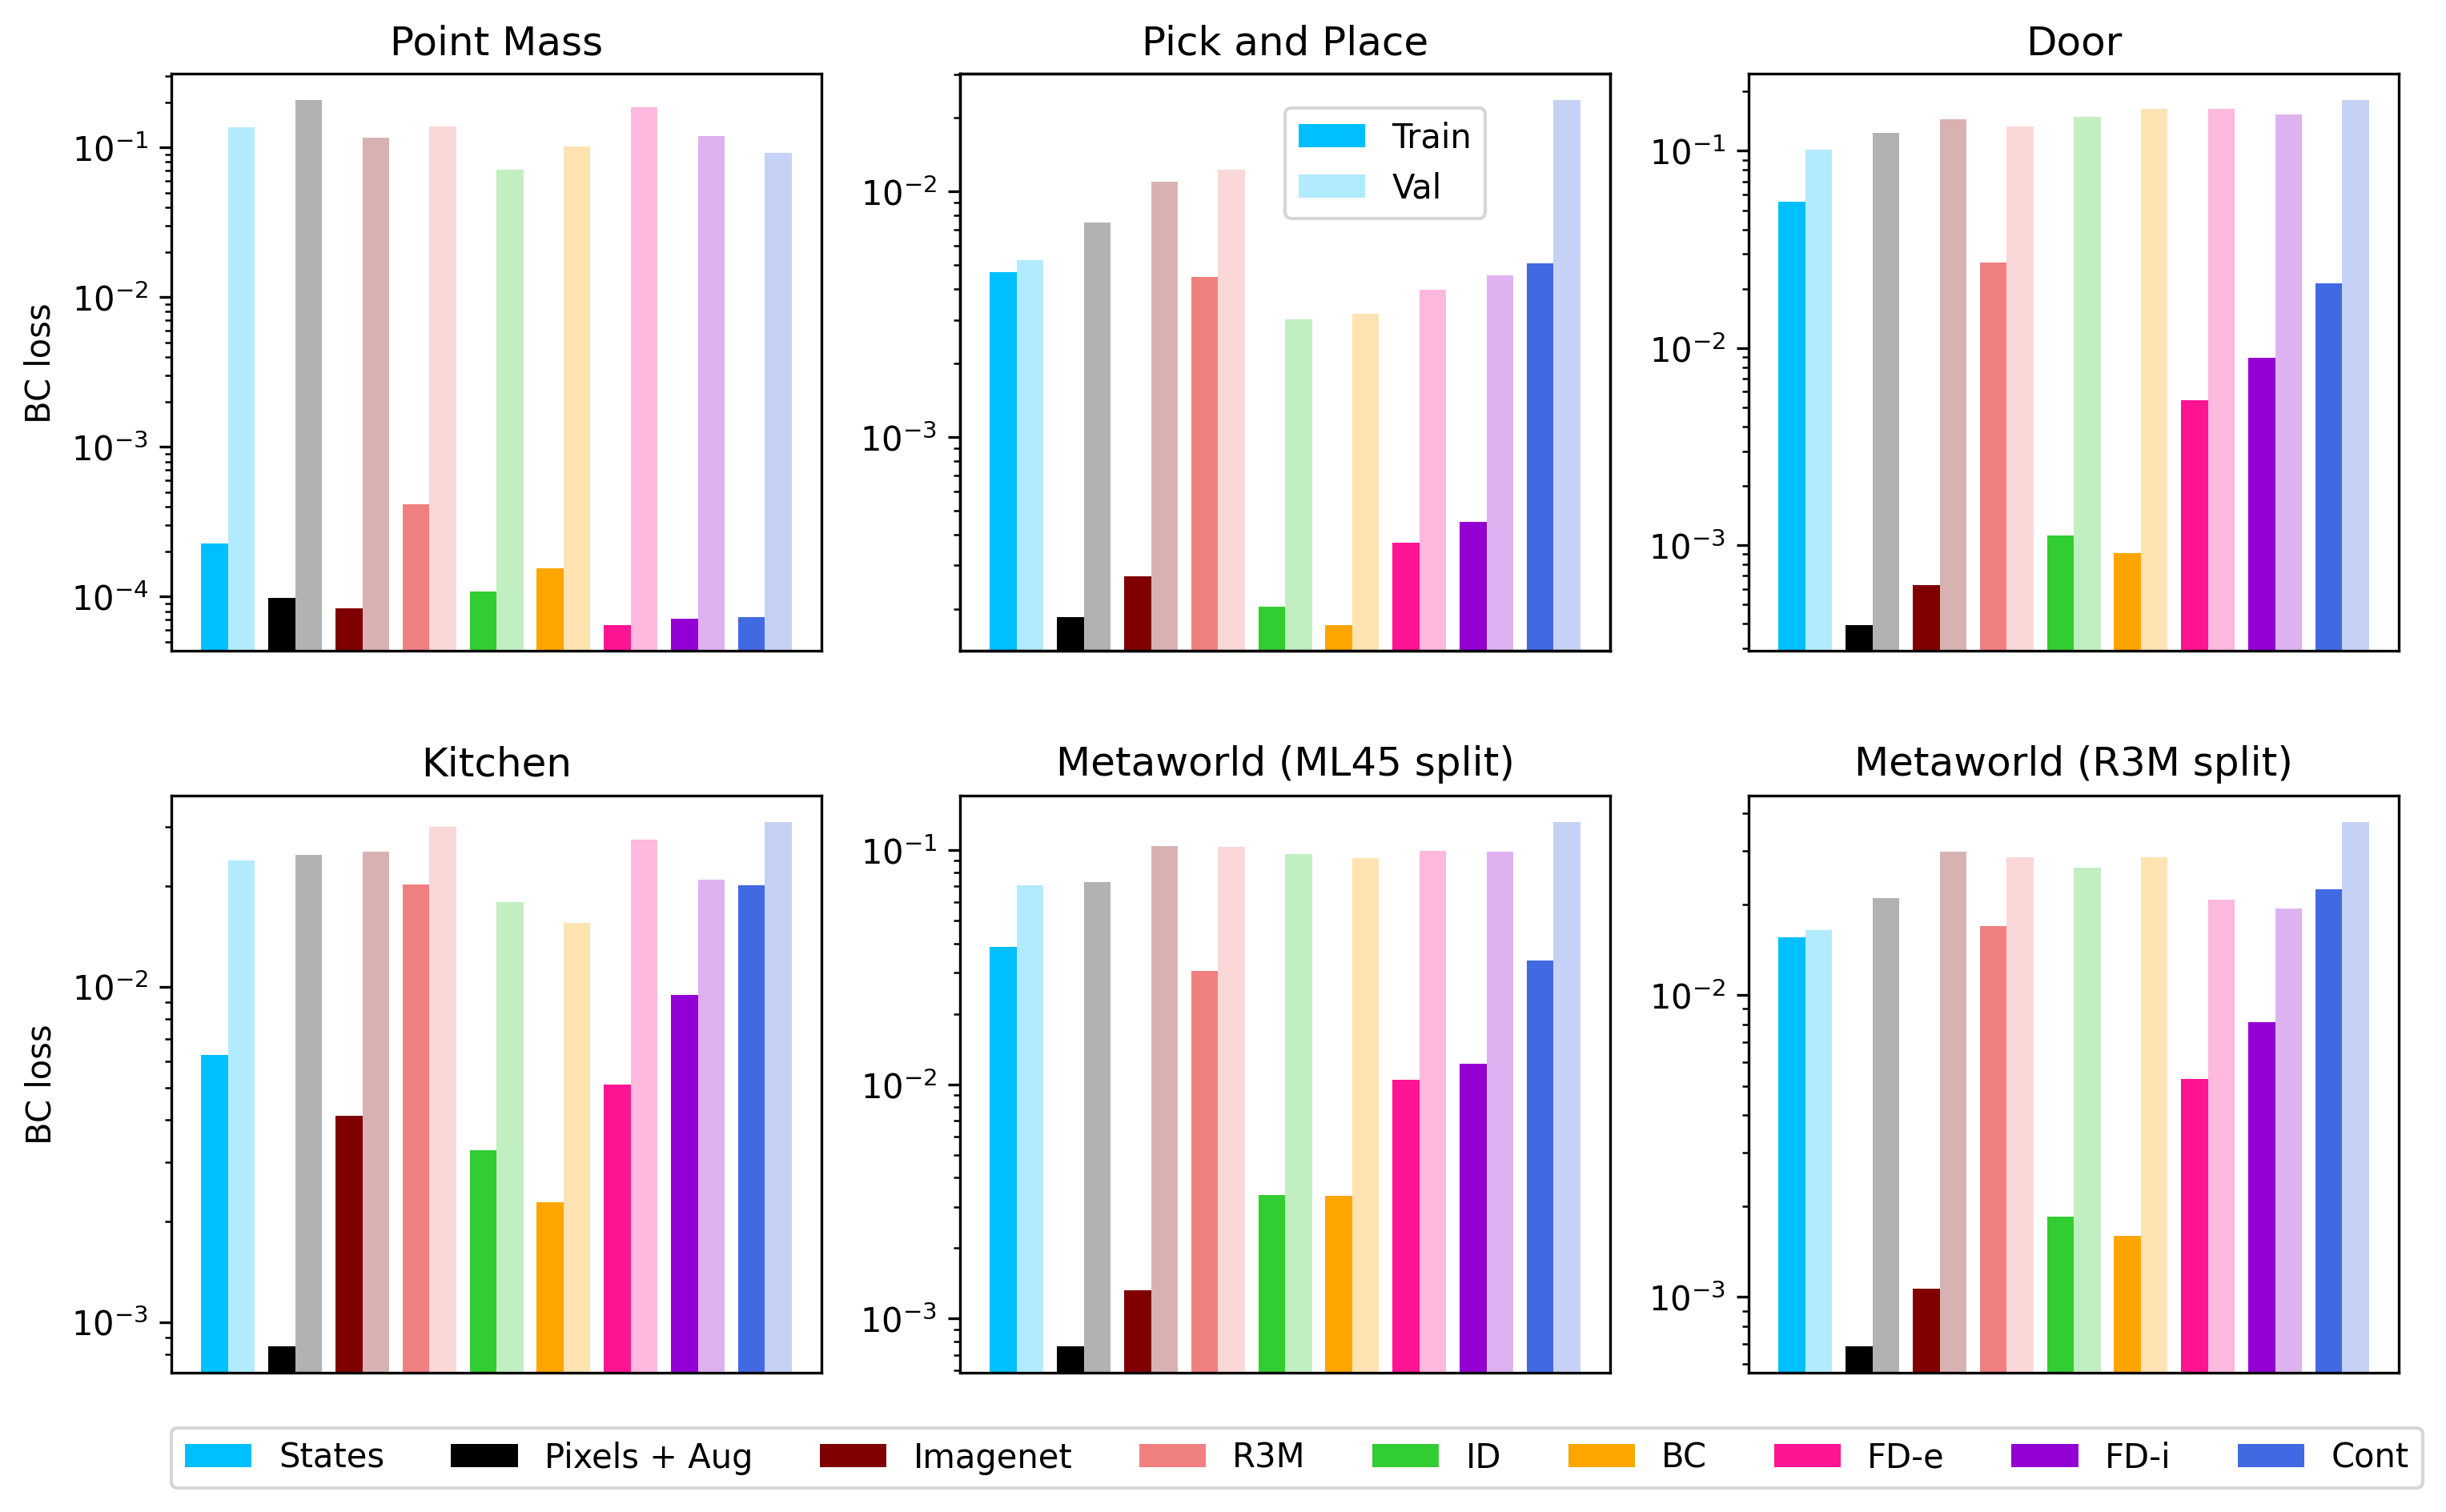

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout()

for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3
    for idx, alg in enumerate(full_results["train"][env_name]):
        
        train_loss = full_results["train"][env_name][alg]["means"]#[idx]
        val_loss = full_results["val"][env_name][alg]["means"]#[idx]

        axs[x,y].bar(
            idx, train_loss, bottom = 0, width=0.4,
            alpha=1.0, color=color_dict[alg], label=label_dict[alg]
        )
        axs[x,y].bar(
            idx+0.4, val_loss, bottom = 0, width=0.4,
            alpha=0.3, color=color_dict[alg],
        )

    axs[x,y].set_xticks([]) #[j + 0.45 for j in range(4)], x_axis)
    axs[x,y].set_title(label_dict[env_name])
    axs[x,y].set_yscale("log")
    if x == 1 and y == 0:
        axs[x,y].legend(loc=(0.0, -0.2), ncol=9)
    if y == 0:
        axs[x,y].set_ylabel("BC loss")

ax2 = axs[0,1].twinx()
alphas = [1.0, 0.3]
labels = ["Train", "Val"]
for i in range(2):
    ax2.bar(np.NaN, np.NaN, alpha=alphas[i], label=labels[i],  color='deepskyblue')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc=(0.5, 0.75))

fig.subplots_adjust(hspace=0.25)
plt.show()

# Figure 7 + appendix (State pred loss)

In [22]:
def label_f(g): # not actually used here (size is filtered in sweep)
    return g["max_episodes"]

def filter_pretrain(g, env_name, enc_name, nstep, target_enc_name, target_nstep, mode=None):
    if enc_name == "States":
        enc_name = None
    if target_enc_name == "States":
        target_enc_name = None
    enc_match = enc_name == g["encoder_name"] and target_enc_name == g["target_encoder_name"]
    
    if enc_name is not None:
        enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
    if target_enc_name is not None:
        enc_match = enc_match and target_nstep == g["target_encoder_config"]["nstep"]
    
    return (enc_match and env_match(env_name, g["eval_env_name"]) 
            and g["target_encoder_name"] == None)

date = "May-2023"
load_ids = ["33403527"]

def state_pred_results(date, load_ids, mode):
    args_dict = visualization.get_args_dict(date, load_ids, pop_unlearned=True)

    args_dict["States"] = {"filter_args": {"enc_name": "States", "nstep": -1}, 
                           "sweep_ids": load_ids, "date": date}
    # args_dict.pop("States")

    for k in args_dict:
        args_dict[k]["csv_mode"] = mode
        args_dict[k]["csv_key"] = "actor_loss"

    target_args_dict = args_dict.copy()
    product_dict = {}
    for k in args_dict:
        for j in target_args_dict:
            product_dict[f"{k}"] = dict(
                                args_dict[k],
                                filter_args= dict(
                                    args_dict[k]["filter_args"],
                                    target_enc_name=target_args_dict[j]["filter_args"]["enc_name"],
                                    target_nstep=target_args_dict[j]["filter_args"]["nstep"]
                                    )
                                )
    product_dict.pop("States")

    return visualization.get_full_results(root_path, envs, filter_pretrain, label_f, product_dict)[0]

train_results = state_pred_results(date, load_ids, "train")
val_results = state_pred_results(date, load_ids, "val")

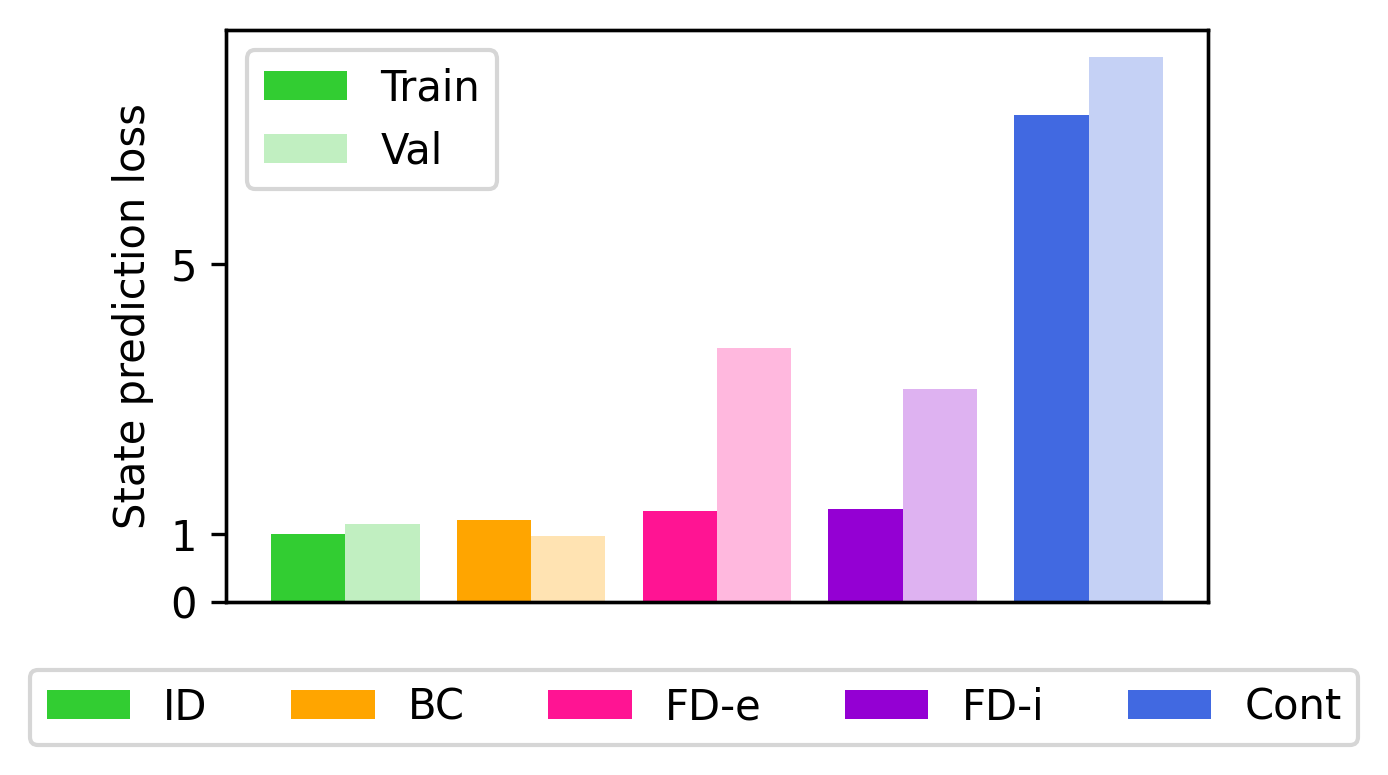

In [23]:
# Normalize results
norms = {}
for env,env_dict in val_results.items():
    norms[env] = 1.0 * train_results[env]["inverse_dynamics"]["means"][-1]

avg_results = {}    
avg_results["train"] = visualization.get_avg(train_results, norms)
avg_results["val"] = visualization.get_avg(val_results, norms)


fig, ax = plt.subplots(1, 1, figsize=(4, 2.5))
fig.tight_layout()

idx = 0
for loc, alg in enumerate(avg_results["train"]):
    train_loss = avg_results["train"][alg]["means"][idx]
    val_loss = avg_results["val"][alg]["means"][idx]

    ax.bar(
        loc, train_loss, bottom = 0, width=0.4,
        alpha=1.0, color=color_dict[alg], label=label_dict[alg]
    )
    ax.bar(
        loc + 0.4, val_loss, bottom = 0, width=0.4,
        alpha=0.3, color=color_dict[alg],
    )
    
ax.set_xticks([])
ax.set_yticks([0, 1, 5], [0,1,5])
ax.legend(loc=(-0.2, -0.25), ncol=5)
ax.set_ylabel("State prediction loss")

ax2 = ax.twinx()
alphas = [1.0, 0.3]
labels = ["Train", "Val"]
for i in range(2):
    ax2.bar(np.NaN, np.NaN, alpha=alphas[i], label=labels[i],  color='limegreen')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc="upper left")
        

fig.subplots_adjust(hspace=0.25)
plt.show()

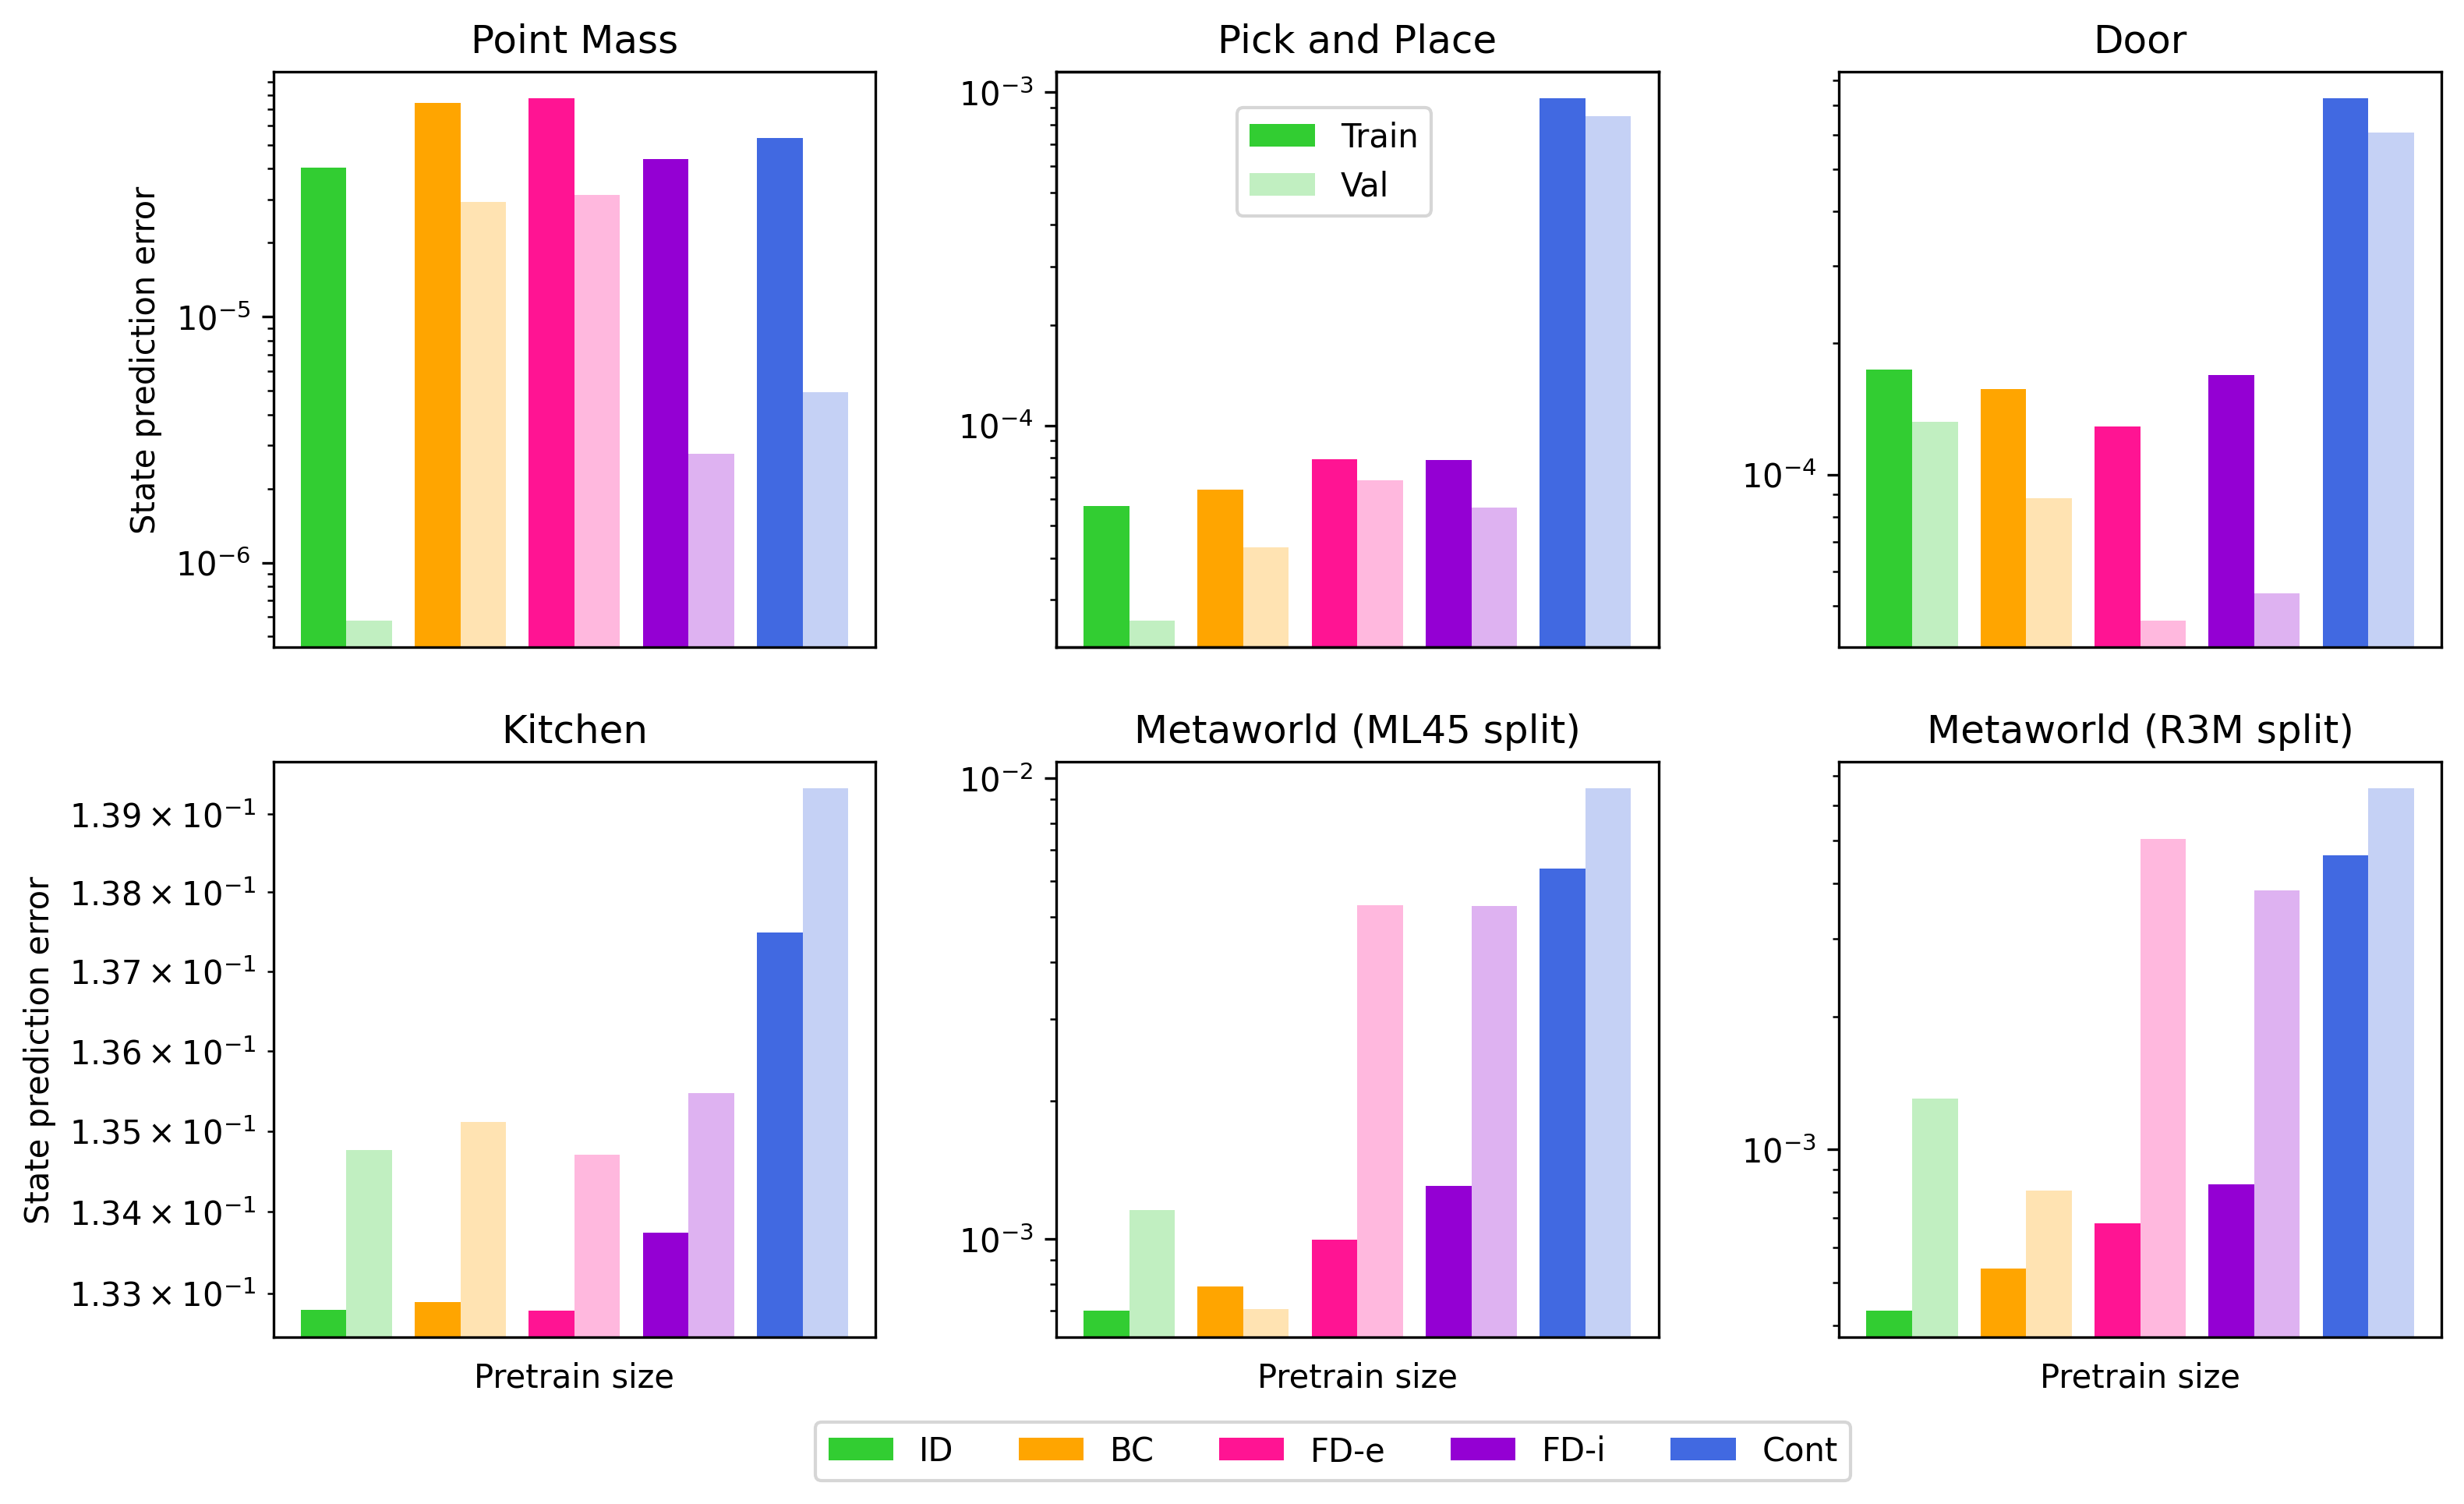

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout() 
for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3

    for loc, alg in enumerate(train_results[env_name]):

        train_loss = train_results[env_name][alg]["means"]
        val_loss = val_results[env_name][alg]["means"]
        axs[x,y].bar(
            loc, train_loss, bottom = 0, width=0.4,
            alpha=1.0, color=color_dict[alg], label=label_dict[alg]
        )
        axs[x,y].bar(
            loc + 0.4, val_loss, bottom = 0, width=0.4,
            alpha=0.3, color=color_dict[alg],
        )

    axs[x,y].set_xticks([])
    axs[x,y].set_title(label_dict[env_name])
    axs[x,y].set_yscale("log")
    if y == 0:
        axs[x,y].set_ylabel("State prediction error")
    if x == 1:
        axs[x,y].set_xlabel("Pretrain size")

    if x == 1 and y == 0:
        axs[x,y].legend(loc=(0.9, -0.25), ncol=5)

ax2 = axs[0,1].twinx()
alphas = [1.0, 0.3]
labels = ["Train", "Val"]
for i in range(2):
    ax2.bar(np.NaN, np.NaN, alpha=alphas[i], label=labels[i],  color='limegreen')
ax2.get_yaxis().set_visible(False)
ax2.legend(loc=(0.3, 0.75))

fig.subplots_adjust(hspace=0.2, wspace=0.3)
plt.show()

# Figure 8 (encoder manifold)

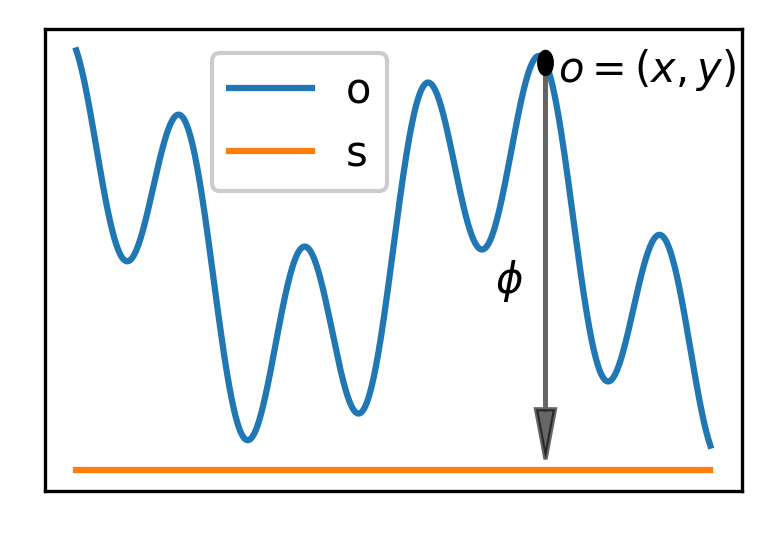

In [25]:
fig, ax = plt.subplots(1,1, figsize=(3,2))

def f(x):
    return np.sin(x) + np.sin((10.0 / 3.0) * x)
    
x = np.linspace(-5, 5, 1000)
ax.plot(x, f(x), label="o")
ax.plot(x, [-2] * len(x), label = "s")

c = patches.Circle((2.4, f(2.4)), radius=0.1, color="black", zorder=2)
ax.add_patch(c)
ax.arrow(2.4, f(2.4), 0, - f(2.4) - 1.9, head_width= 0.3, length_includes_head=True, color="black", alpha=0.6)

ax.annotate("$o=(x,y)$", xy=(2.6, 1.5))
ax.annotate("$\phi$", xy=(1.6, -0.4))

ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc=(0.24, 0.65), framealpha=1)
plt.show()

# Cross representation prediction (appendix)

In [26]:
def label_f(g): # not actually used here (size is filtered in sweep)
    return g["max_episodes"]

def filter_pretrain(g, env_name, enc_name, nstep, target_enc_name, target_nstep, mode=None):
    if enc_name == "States":
        enc_name = None
    if target_enc_name == "States":
        target_enc_name = None
    enc_match = enc_name == g["encoder_name"] and target_enc_name == g["target_encoder_name"]
    
    if enc_name is not None:
        enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
    if target_enc_name is not None:
        enc_match = enc_match and target_nstep == g["target_encoder_config"]["nstep"]
    return enc_match and env_match(env_name, g["eval_env_name"])

date = "May-2023"
load_ids = ["33403527"] 
args_dict = visualization.get_args_dict(date, load_ids, pop_unlearned=True)

for k in args_dict:
    args_dict[k]["csv_mode"] = "val"
    args_dict[k]["csv_key"] = "actor_loss"

target_args_dict = args_dict.copy()
product_dict = {}
for k in args_dict:
    for j in target_args_dict:
        product_dict[f"{k}-{j}"] = dict(
                            args_dict[k],
                            filter_args= dict(
                                args_dict[k]["filter_args"],
                                target_enc_name=target_args_dict[j]["filter_args"]["enc_name"],
                                target_nstep=target_args_dict[j]["filter_args"]["nstep"]
                                )
                            )

full_results, _ = visualization.get_full_results(root_path, envs, filter_pretrain, label_f, product_dict)

keys = args_dict.keys()
results_dict = {}
for env in envs:
    results = np.zeros((len(keys), len(keys)))
    for i, source in enumerate(keys):
        results_row = {k[len(source) + 1:]: v["means"] for k, v in full_results[env].items() if k.startswith(source)}
        for j, target in enumerate(keys):
            try:
                results[i,j] = results_row[target]
            except:
                results[i,j] = np.nan
    results_dict[env] = results

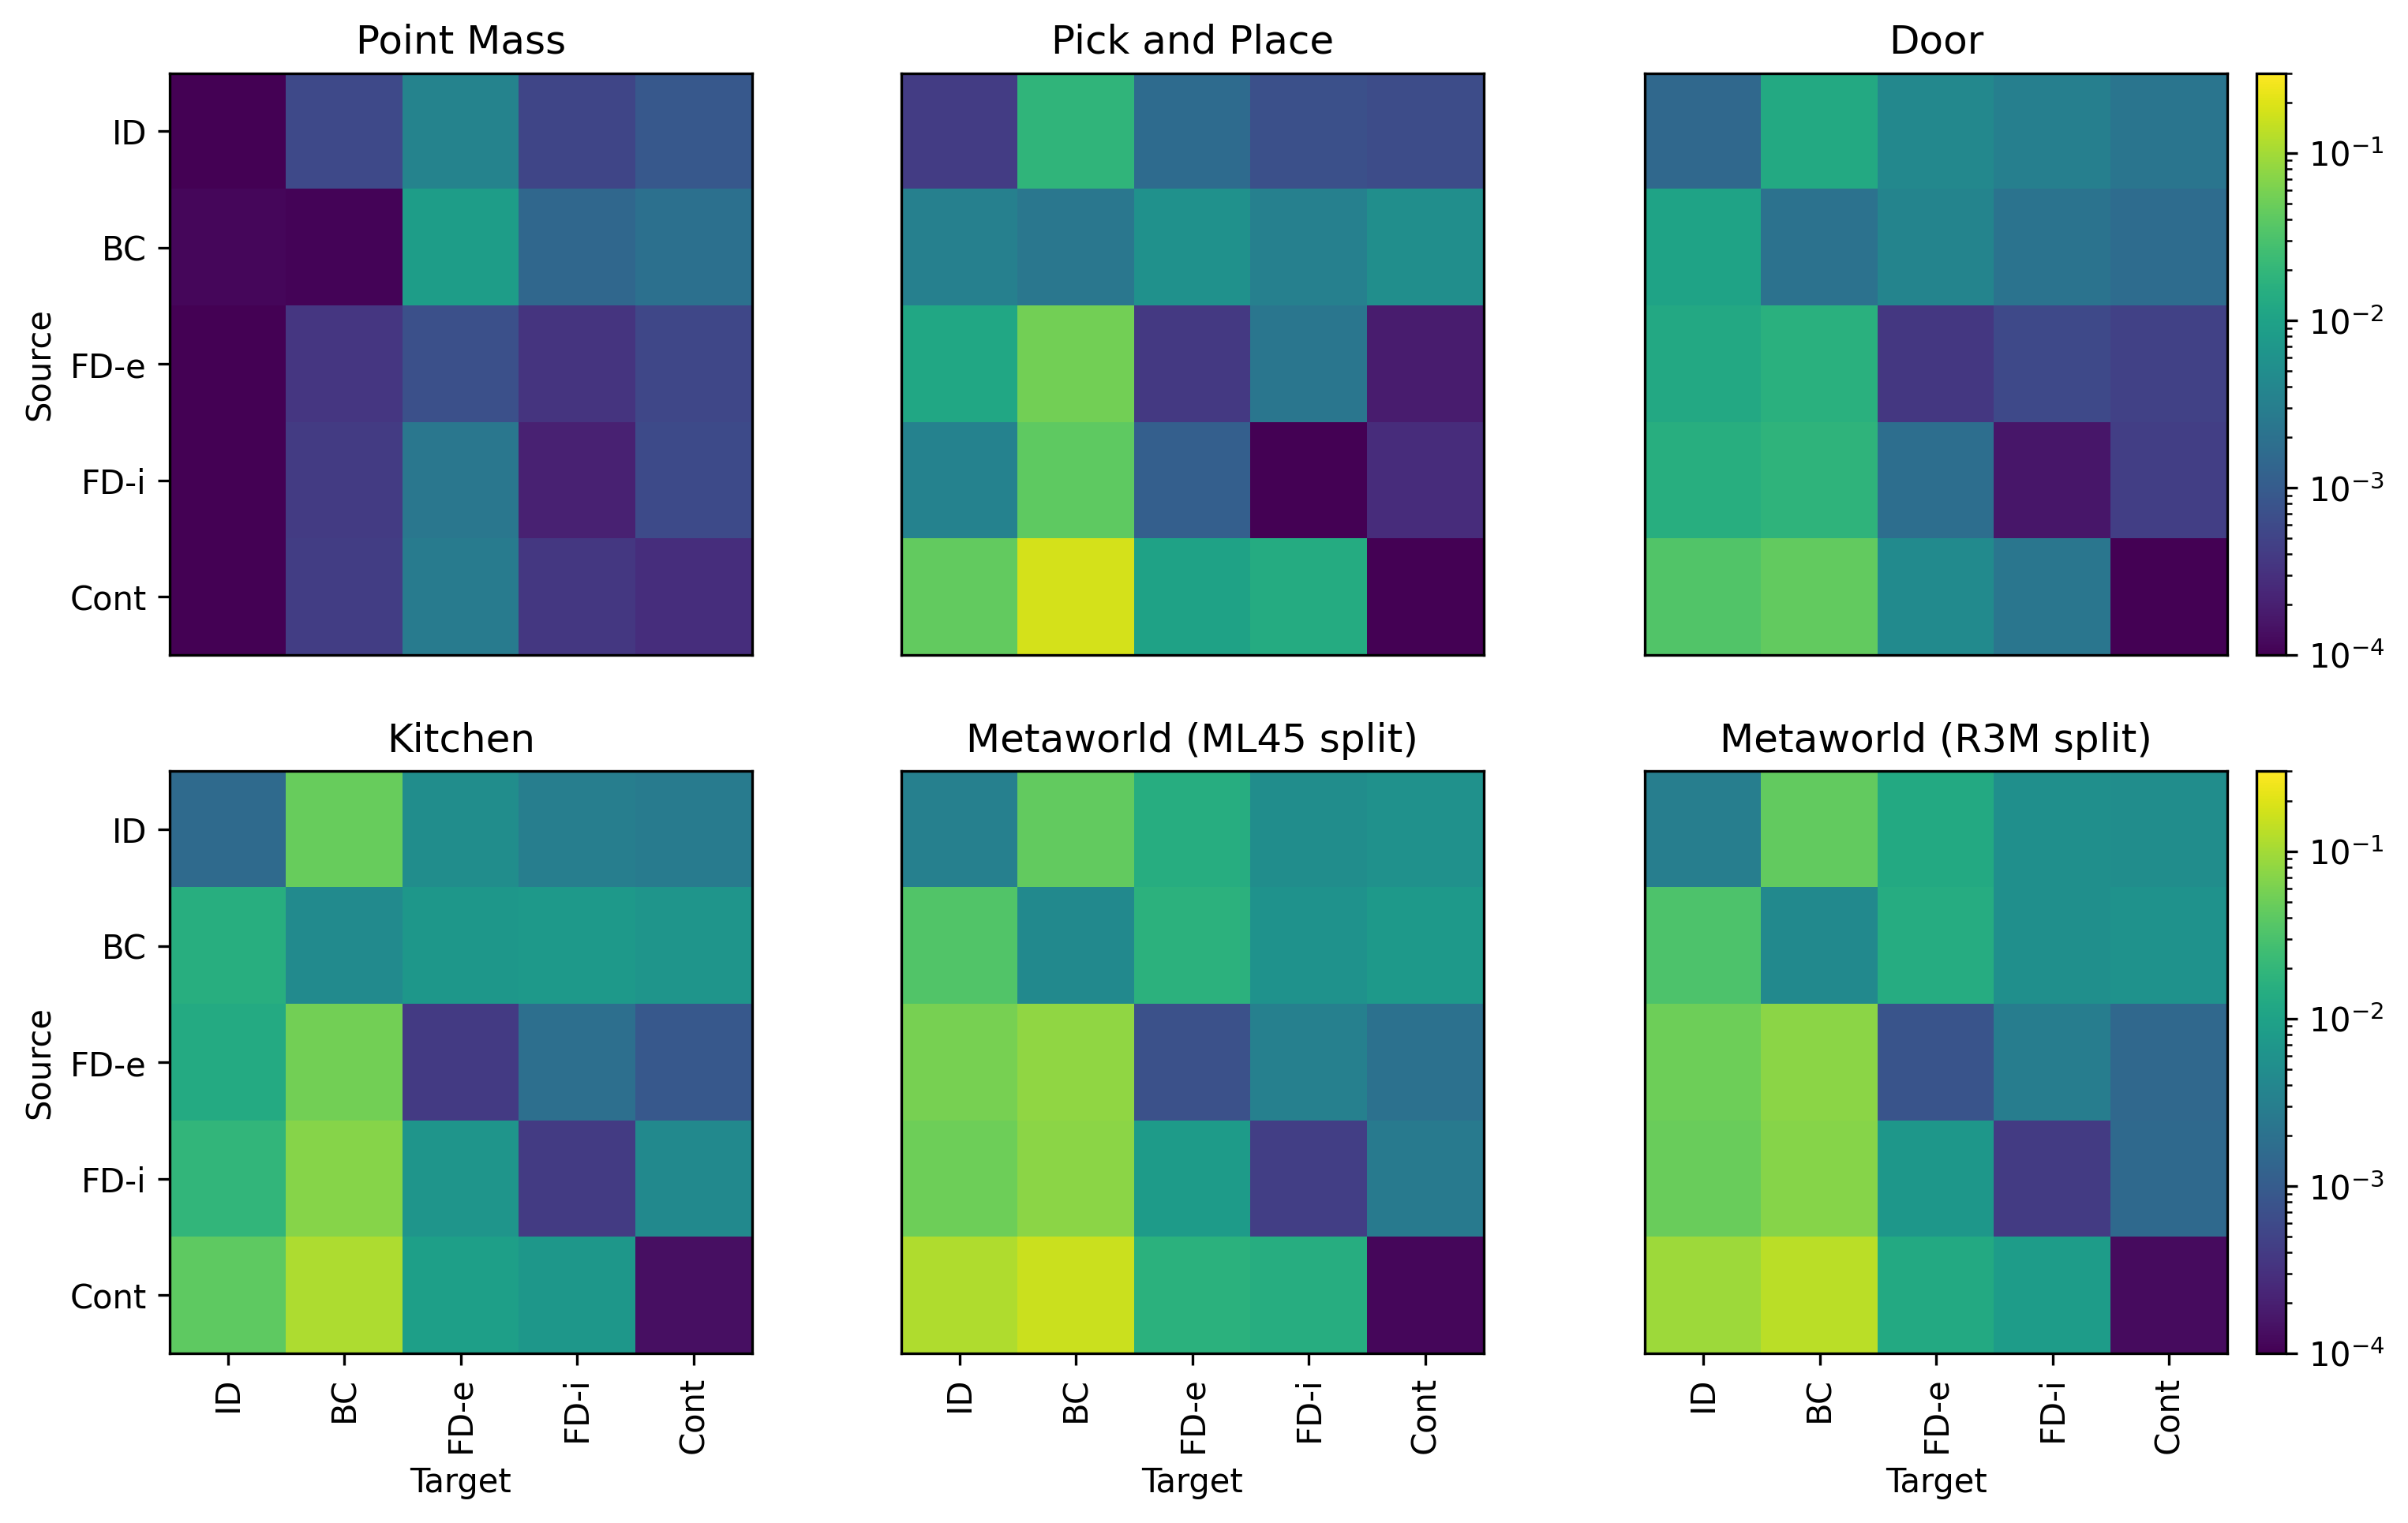

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout() 

labels = [label_dict[k] for k in keys]

for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3

    im = axs[x,y].imshow(results_dict[env_name], norm="log", vmin=1e-4, vmax=0.3)
    
    axs[x,y].set_title(label_dict[env_name])
    if y == 2:
        plt.colorbar(im, ax=axs[x,y], fraction=0.046, pad=0.04)
    if x == 1:
        axs[x,y].set_xlabel("Target")
        axs[x,y].set_xticks(range(len(keys)), labels, rotation='vertical')
    else:
        axs[x,y].set_xticks([])
    if y == 0:
        axs[x,y].set_ylabel("Source")
        axs[x,y].set_yticks(range(len(keys)), labels)
    else:
        axs[x,y].set_yticks([])

fig.subplots_adjust(hspace=0.2, wspace=0.0)
plt.show()

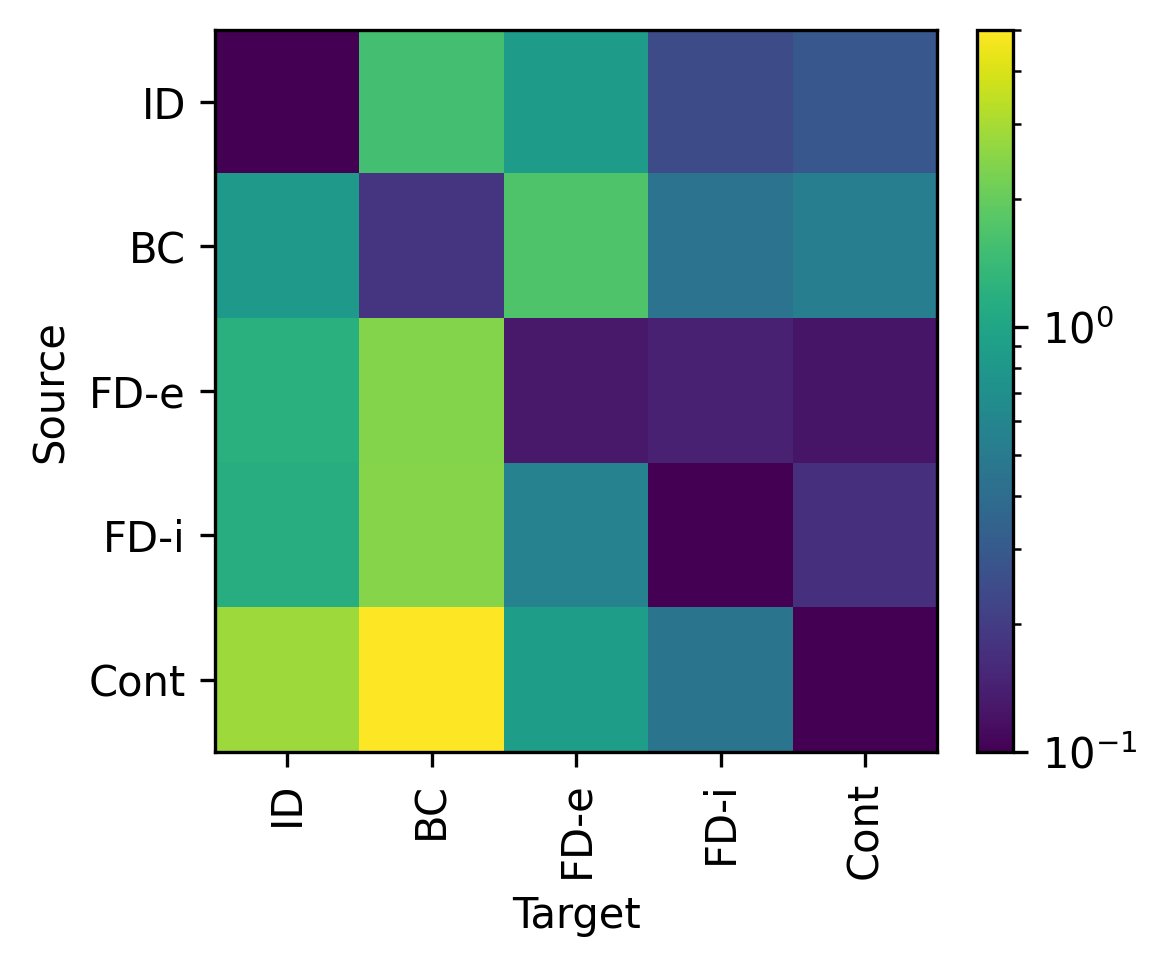

In [28]:
# Normalize results
norms = {k: np.mean(results_dict[k]) for k in results_dict}
avg_results = np.mean(np.stack([results_dict[k] / norms[k] for k in results_dict]), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
fig.tight_layout() 

labels = [label_dict[k] for k in keys]

im = ax.imshow(avg_results, norm="log", vmin=1e-1, vmax=5)

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xlabel("Target")
ax.set_xticks(range(len(keys)), labels, rotation='vertical')

ax.set_ylabel("Source")
ax.set_yticks(range(len(keys)), labels)


fig.subplots_adjust(hspace=0.2, wspace=0.0)
plt.show()

# Note: the diagonal error somehow measure how many OOD representations are encountered in the val set.
# Those points are relying on generalization of the network

# N step ablation (appendix)

In [29]:
def plot_errorbar(ax, keys, means, stds, label, show_std=True, linestyle="solid"):
    ax.plot(keys, means, color=color_dict[label], label=label_dict.get(label, label), linestyle=linestyle)
    if show_std:
        ax.fill_between(keys, means-stds, means+stds, 
                         alpha=0.1, color=color_dict[label])

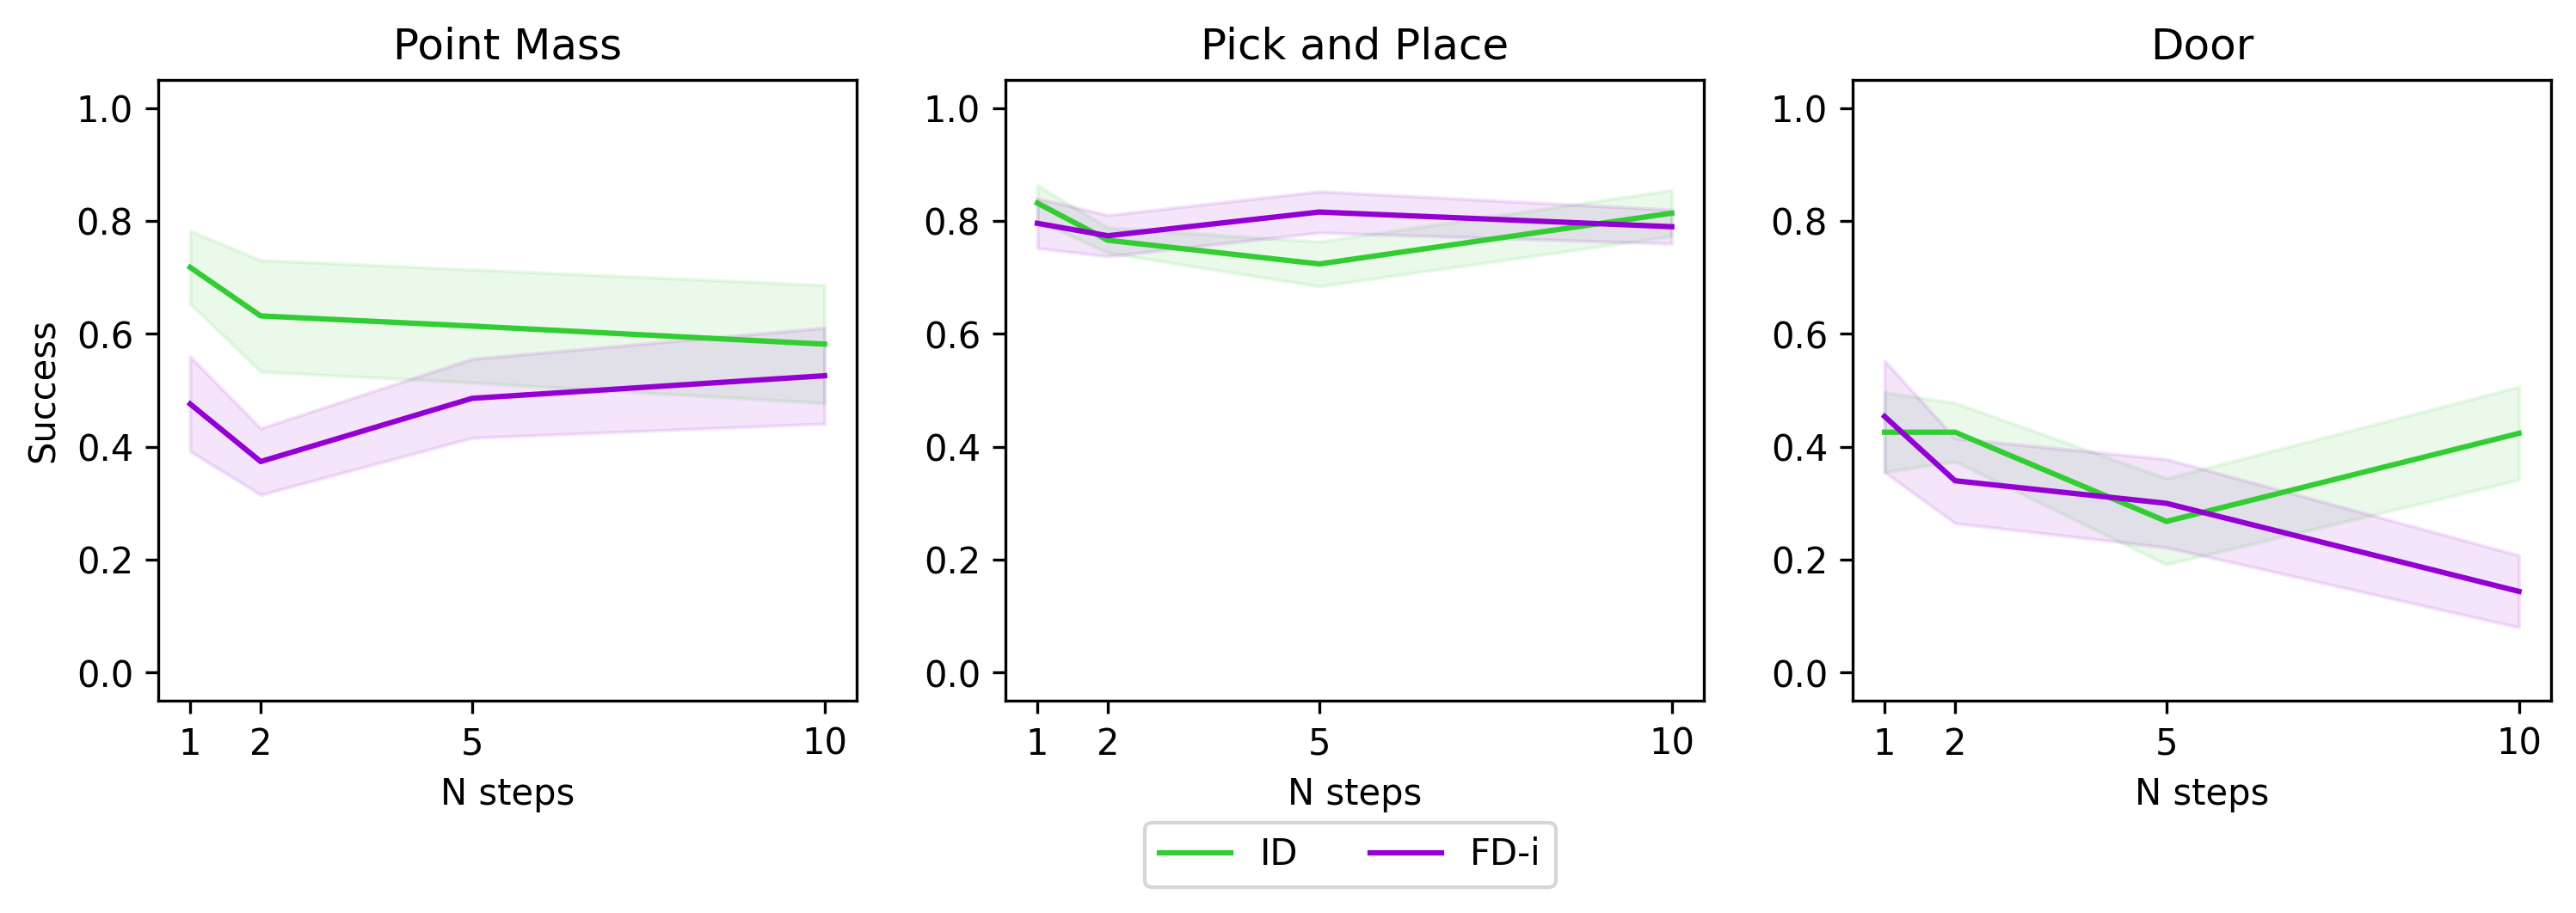

In [30]:
def label_f(g):
    return g["encoder_config"]["nstep"]

def filter_func(g, env_name, mode, obs_name=None, enc_name=None, nstep=1):
    size_match = g["max_episodes"] == ft_defaults[g["eval_env_name"]]
    enc_match = enc_name in g["encoder_name"]
    return enc_match and env_match(env_name, g["eval_env_name"]) and size_match and g["encoder_config"]["nstep"] > 0


less_envs = ["point_mass", "metaworld_pick_place", "metaworld_door"]
    
date = "May-2023"
finetune_id = ['32939975']
args_dict = visualization.get_args_dict(date, finetune_id)
args_dict = {k:v for k,v in args_dict.items() if k in ['inverse_dynamics', 'contrastive']}
full_results, _ = visualization.get_full_results(root_path, less_envs, filter_func, label_f, args_dict)

date = "Apr-2023"
finetune_id = ['32850691']
args_dict = visualization.get_args_dict(date, finetune_id)
args_dict = {k:v for k,v in args_dict.items() if k in ['inverse_dynamics', 'contrastive']}
full_results_2, _ = visualization.get_full_results(root_path, less_envs, filter_func, label_f, args_dict)

def merge_results(r1, r2):
    for env in r1:
        for alg in r1[env]:
            if env in r2 and alg in r2[env]:
                r1[env][alg]["means"] = np.concatenate([r1[env][alg]["means"], r2[env][alg]["means"]])
                r1[env][alg]["stds"] = np.concatenate([r1[env][alg]["stds"], r2[env][alg]["stds"]])
                r1[env][alg]["keys"] = np.concatenate([r1[env][alg]["keys"], r2[env][alg]["keys"]])

merge_results(full_results_2, full_results)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
fig.tight_layout()
for i, env_name in enumerate(envs[:3]):
    y = i % 3
    for key, value in full_results_2[env_name].items():
        plot_errorbar(axs[y], value["keys"], value["means"], value["stds"], key, show_std=True)
        x_axis = value["keys"]
    axs[y].set_xticks(x_axis)
    axs[y].set_title(label_dict[env_name])
    axs[y].set_ylim(-0.05,1.05)
    axs[y].set_xlabel("N steps")
    if y == 1:
        axs[y].legend(loc=(0.2, -0.3), ncol=2)
    if y == 0:
        axs[y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

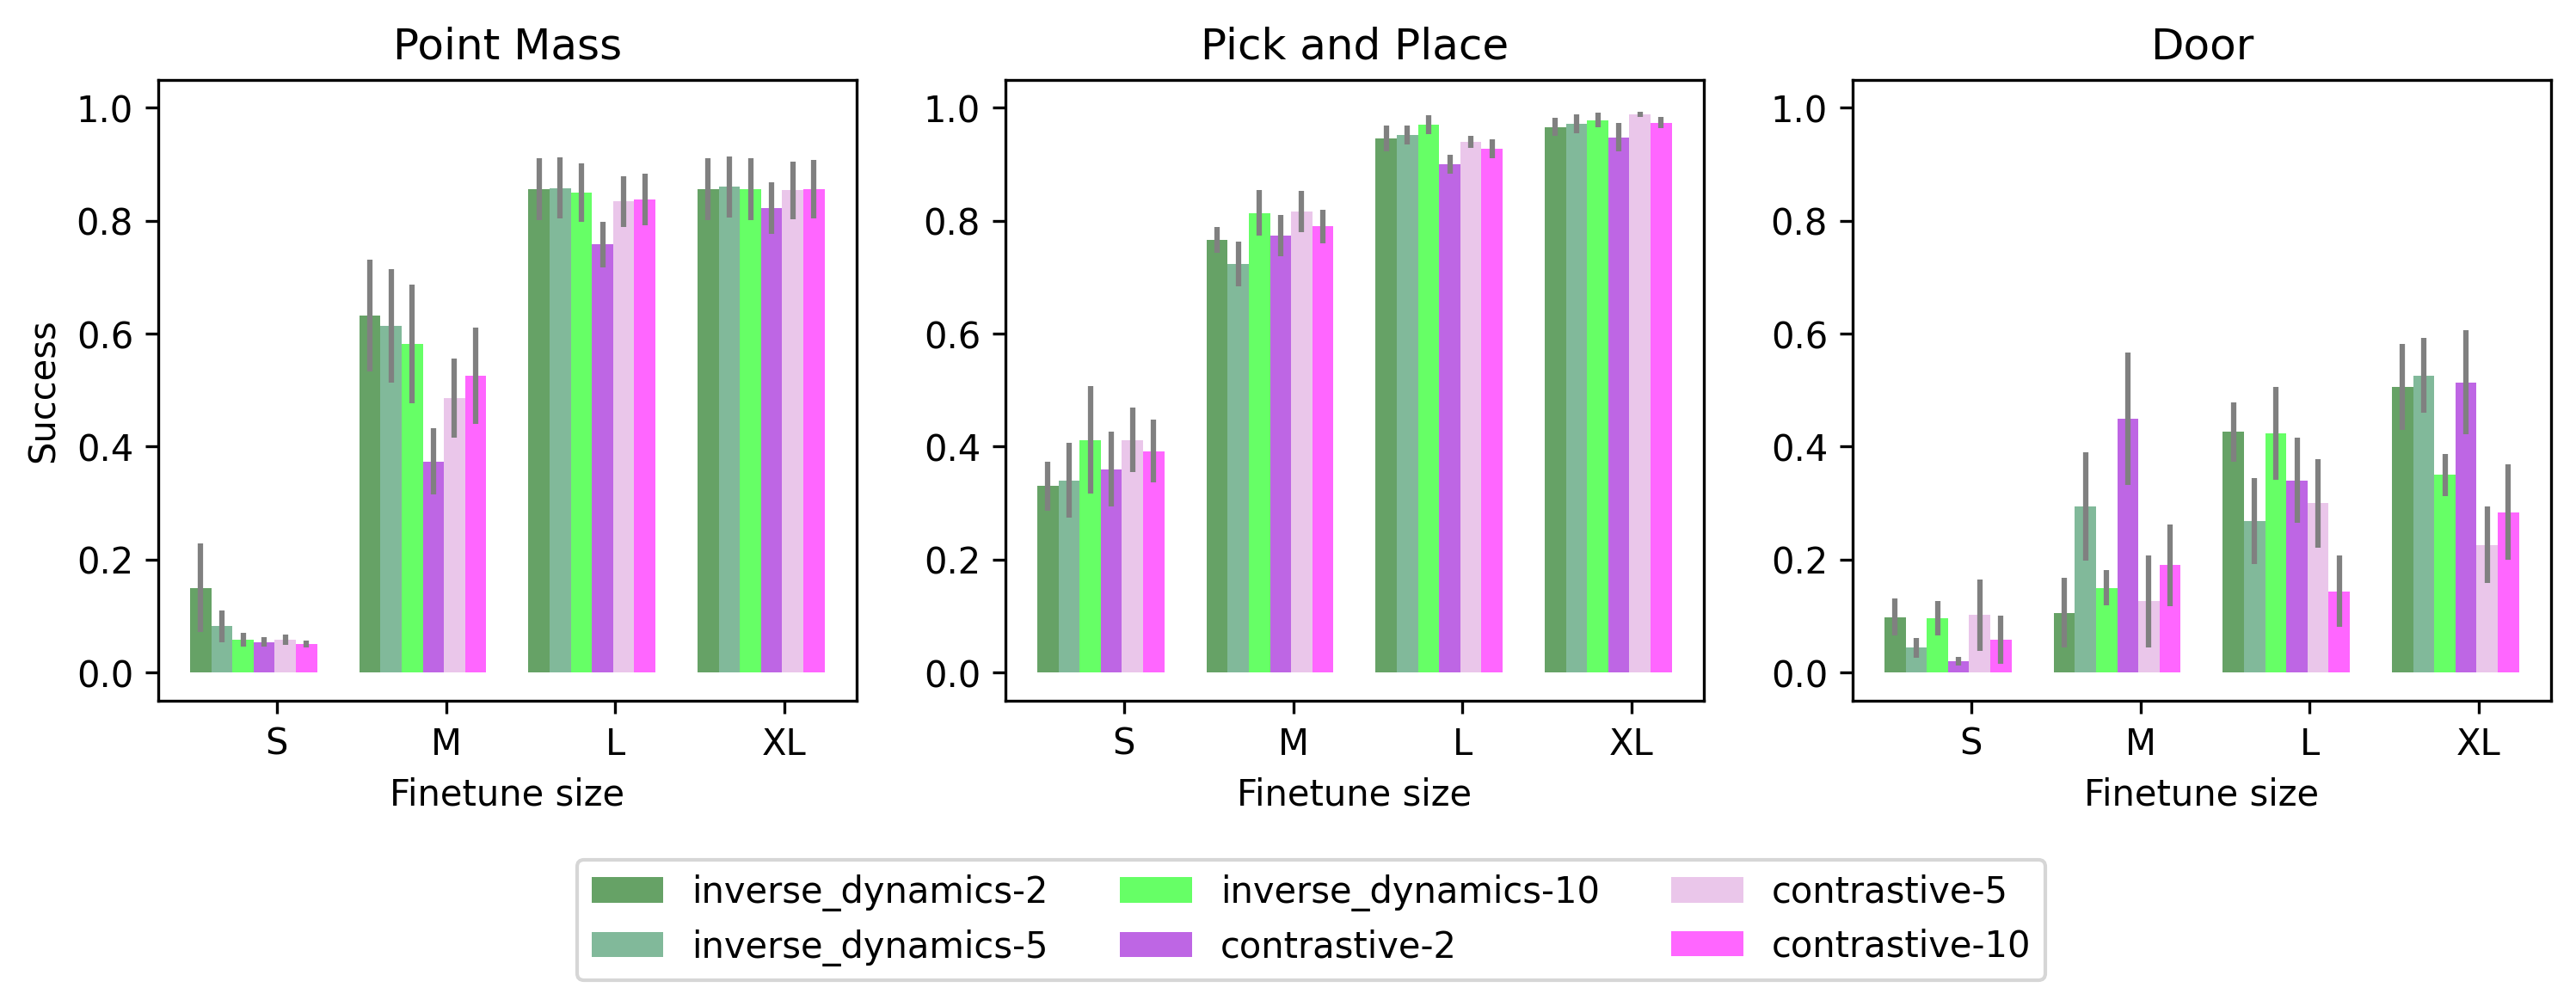

In [31]:
from copy import deepcopy
def label_f(g):
    return g["max_episodes"]

def filter_func(g, env_name, mode, obs_name=None, enc_name=None, nstep=1):
    if mode == "scratch":
        obs_match = obs_name in g["observation_adapter_name"]
        return obs_match and env_match(env_name, g["eval_env_name"])
    elif mode == "finetune":
        enc_match = enc_name in g["encoder_name"]
        if "nstep" in g["encoder_config"]:
            enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
        return enc_match and env_match(env_name, g["eval_env_name"])
    else:
        raise NotImplemented

    
date = "May-2023"

finetune_id = ['32939975']

args_dict = visualization.get_args_dict(date, finetune_id)

args_dict = {k:v for k,v in args_dict.items() if k in ['inverse_dynamics', 'contrastive']}

new_args_dict = {}
for k,v in args_dict.items():
    for n in [2,5,10]:
        new_args_dict[f"{k}-{n}"] = deepcopy(v)
        new_args_dict[f"{k}-{n}"]['filter_args']['nstep'] = n


full_results, _ = visualization.get_full_results(root_path, less_envs, filter_func, label_f, new_args_dict)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
fig.tight_layout()

bar_size = 8

for i, env_name in enumerate(envs[:3]):
    y = i % 3
    for idx, (key, value) in enumerate(full_results[env_name].items()):
        
        for j in range(4):
            axs[y].bar(j + idx / bar_size, value["means"][j], yerr=value["stds"][j], 
                        width=1/bar_size, alpha=0.6,
                        color=color_dict[key], ecolor="gray",
                        label=key if j == 0 else None)
        
        
    
    
    axs[y].set_xticks([j + 0.45 for j in range(4)], ["S", "M", "L", "XL"])
    axs[y].set_title(label_dict[env_name])
    axs[y].set_ylim(-0.05,1.05)
    axs[y].set_xlabel("Finetune size")
    if y == 0:
        axs[y].legend(loc=(0.6, -0.45), ncol=3)
    if y == 0:
        axs[y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

# BC loss plots (sweep size, deprecated)

In [32]:
def filter_func(g, env_name, mode, obs_name=None, enc_name=None, nstep=1):
    if mode == "scratch":
        obs_match = obs_name in g["observation_adapter_name"]
        return obs_match and env_match(env_name, g["eval_env_name"])
    elif mode == "finetune":
        enc_match = enc_name in g["encoder_name"]
        if "nstep" in g["encoder_config"]:
            enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
        return enc_match and env_match(env_name, g["eval_env_name"])
    
date = "Apr-2023"

# Data size
# finetune_id = ['32838050']

# Large
finetune_id = ['32850691']
# Med
# finetune_id = ['32825791']

args_dict = get_args_dict(date, finetune_id)

args_dict["States"]["sweep_ids"] = ['32608183']
args_dict["Pixels + Aug"]["sweep_ids"] =  ['32608738']

fixed_id = ['32653636']
args_dict["timm"]["sweep_ids"] =  fixed_id
args_dict["r3m"]["sweep_ids"] =  fixed_id

full_results = {}
for csv_mode in ["train", "val"]:

    for k in args_dict:
        args_dict[k]["csv_mode"] = csv_mode
        args_dict[k]["csv_key"] = "actor_loss"
    full_results[csv_mode] = get_full_results(envs, filter_func, label_f, args_dict)

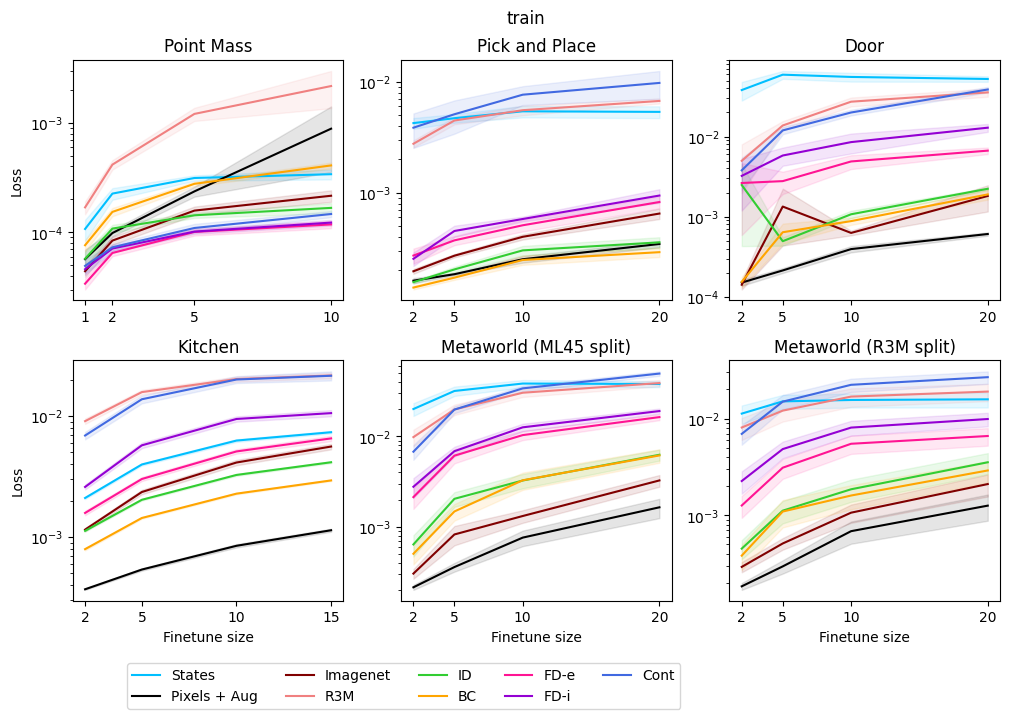

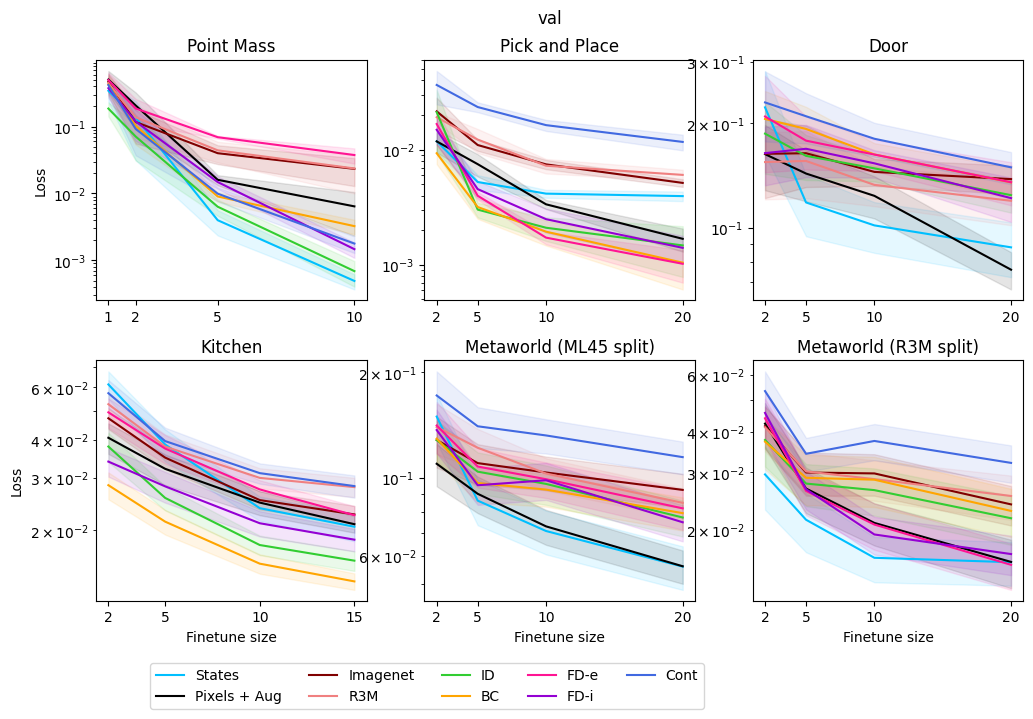

In [33]:
for csv_mode in ["train", "val"]:
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    fig.tight_layout()
    for i, env_name in enumerate(envs):
        y = i % 3
        x = i // 3
        for key, value in full_results[csv_mode][env_name].items():
            plot_errorbar(axs[x, y], *value, key, show_std=True)
            x_axis = value[0]
        axs[x,y].set_xticks(x_axis)
        axs[x,y].set_title(label_dict[env_name])
        #axs[x,y].set_ylim(-0.05,1.05)
        axs[x,y].set_yscale("log")
        if x == 1:
            axs[x,y].set_xlabel("Finetune size")
        if x == 1 and y == 0:
            axs[x,y].legend(loc=(0.2, -0.45), ncol=5)
        if y == 0:
            axs[x,y].set_ylabel("Loss")

    fig.suptitle(csv_mode, y=1.05)
    fig.subplots_adjust(hspace=0.25)
    plt.show()

# Sweep data diversity (deprecated)

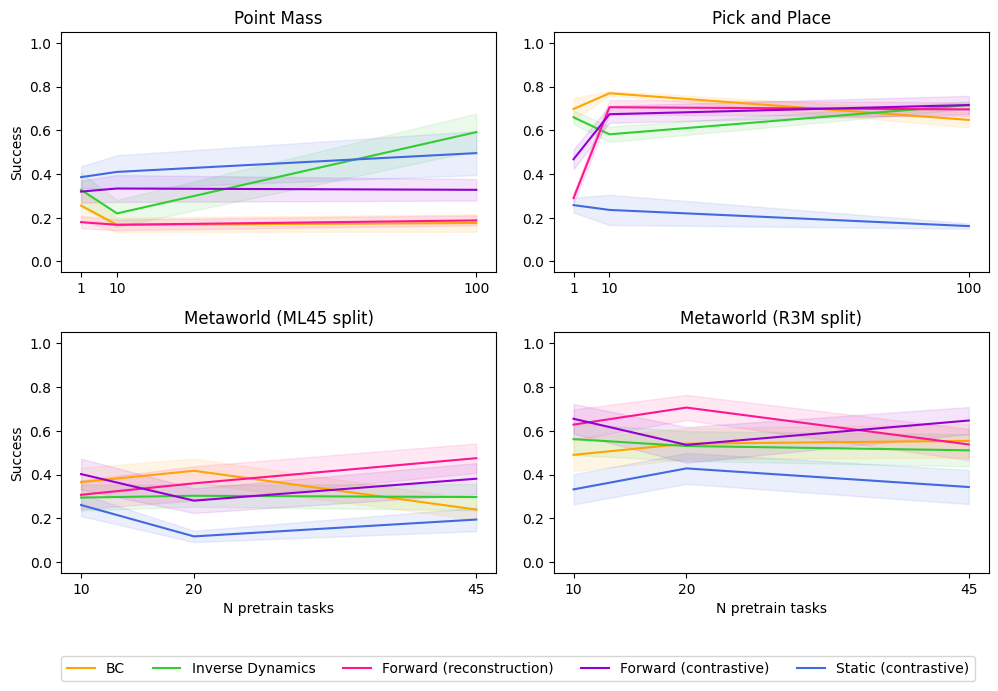

In [27]:
def label_f(g):
    enc_config = g["encoder_config"]
    if "kitchen" in enc_config["eval_env_name"]:
        tasks = enc_config["kitchen_ntasks"]
    elif "ntasks" in enc_config["eval_env_name"]:
        tasks = int(enc_config["eval_env_name"].split("_")[-1])
    else:
        tasks = 100 / enc_config["per"]
    return tasks

def filter_func(g, env_name, enc_name, nstep=1, mode=None, obs_name=None):
    enc_match = enc_name in g["encoder_name"]
    if nstep >= 0:
        enc_match = enc_match and nstep == g["encoder_config"]["nstep"]
    
    return enc_match and env_match(env_name, g["eval_env_name"])
         
    
date = "May-2023"
finetune_id = ['32961927']
args_dict = get_args_dict(date, finetune_id)

for alg in ["States", "Pixels + Aug", "timm", "r3m"]:
    args_dict.pop(alg)
    
full_results = get_full_results(envs, filter_func, label_f, args_dict)


fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.tight_layout()
for i, env_name in enumerate([e for e in envs if "door" not in e and "kitchen" not in e]):
    y = i % 2
    x = i // 2
    for key, value in full_results[env_name].items():
        plot_errorbar(axs[x, y], *value, key, show_std=True)
        x_axis = value[0]
    axs[x,y].set_xticks(x_axis)
    #axs[x,y].set_xscale("log")
    axs[x,y].set_title(label_dict[env_name])
    axs[x,y].set_ylim(-0.05,1.05)
    if x == 1:
        axs[x,y].set_xlabel("N pretrain tasks")
    if x == 1 and y == 0:
        axs[x,y].legend(loc=(0.0, -0.45), ncol=5)
    if y == 0:
        axs[x,y].set_ylabel("Success")
        
fig.subplots_adjust(hspace=0.25)
plt.show()

# Optimizing across objectives (deprecated)

In [339]:
def label_f(g): # not actually used here
    return g["max_episodes"]

def filter_pretrain(g, env_name, enc_name, enc_nstep, agent_name, nstep, mode=None):
    enc_match = (
        enc_name == g["encoder_name"]
        and enc_nstep == g["encoder_config"]["nstep"]
        and agent_name == g["agent_name"]
        and nstep == g["nstep"]
    )   
    return enc_match and env_match(env_name, g["eval_env_name"])

date = "Apr-2023"
load_ids = ["32837523"]
args_dict = get_args_dict(date, load_ids, pop_unlearned=True)

for k in args_dict:
    args_dict[k]["csv_mode"] = "val"

args_dict["contrastive"]["csv_key"] = "rep_loss"
args_dict["SimCLR"]["csv_key"] = "rep_loss"
args_dict["bc"]["csv_key"] = "actor_loss"
args_dict["inverse_dynamics"]["csv_key"] = "action_loss"

encoder_args_dict = args_dict.copy()
product_dict = {}
for k in args_dict:
    for j in encoder_args_dict:
        product_dict[f"{k}-{j}"] = dict(
                            args_dict[k],
                            filter_args= dict(
                                args_dict[k]["filter_args"],
                                agent_name=args_dict[k]["filter_args"]["enc_name"],
                                enc_name=encoder_args_dict[j]["filter_args"]["enc_name"],
                                enc_nstep=encoder_args_dict[j]["filter_args"]["nstep"],
                                )
                            )

full_results = get_full_results(envs, filter_pretrain, label_f, product_dict)

In [340]:
keys = args_dict.keys()
results_dict = {}
for env in envs:
    results = np.zeros((len(keys), len(keys)))
    if full_results[env] == {}:
        results_dict[env] = results
        continue
    for i, key in enumerate(keys):
        if key == "reconstruction":
            continue
        results_row = {k[len(key) + 1:]: v[1] for k, v in full_results[env].items() if k.startswith(key)}
        
        # Normalize by diagonal entry
        diagonal = results_row[key]
        results_row = {k: v / diagonal for k,v in results_row.items()}
        
        for j, col_key in enumerate(keys):
            try:
                results[i,j] = results_row[col_key]
            except:
                results[i,j] = np.nan
    results_dict[env] = results

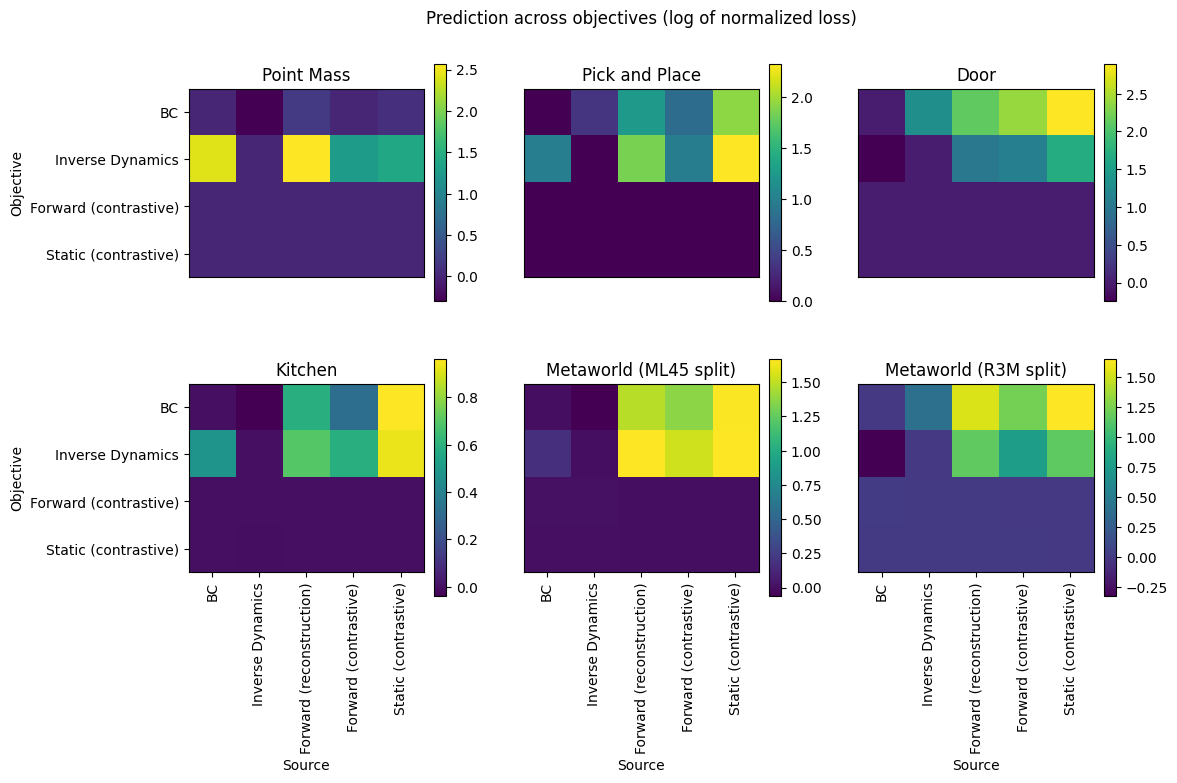

In [341]:
# Plot normalized AND log scaled

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.tight_layout() 

labels = [label_dict[k] for k in keys]

for i, env_name in enumerate(envs):
    y = i % 3
    x = i // 3
    
    im = results_dict[env_name]
    im = np.concatenate([im[:2], im[3:]], axis=0)
    
    im = axs[x,y].imshow(np.log(im))
    #im = axs[x,y].imshow(im)
    
    axs[x,y].set_title(label_dict[env_name])
    plt.colorbar(im, ax=axs[x,y], fraction=0.046, pad=0.04)
    if x == 1:
        axs[x,y].set_xlabel("Source")
        axs[x,y].set_xticks(range(len(keys)), labels, rotation='vertical')
    else:
        axs[x,y].set_xticks([])
    if y == 0:
        axs[x,y].set_ylabel("Objective")
        new_keys = [k for k in keys if k != "reconstruction"]
        axs[x,y].set_yticks(range(len(new_keys)), [label_dict[k] for k in new_keys])
    else:
        axs[x,y].set_yticks([])

fig.suptitle("Prediction across objectives (log of normalized loss)", y=1.05)
fig.subplots_adjust(hspace=0.2, wspace=0.3)
plt.show()